In [2]:
"""
There are several independent analysis scripts contained within this notebook.
""";


In [3]:
"""
A simple azimuthal integration, with and without clustering.
"""
import importlib

import numpy as np

import parsing_utils as utils
import ccd_image as ccd
import cluster

importlib.reload(utils)
importlib.reload(ccd)
importlib.reload(cluster)

mean_bkg_subbed_data = \
    np.zeros_like(utils.get_rough_background(utils.SCAN_DIRS[0]))
mean_bkg_in_clusters = \
    np.zeros_like(utils.get_rough_background(utils.SCAN_DIRS[0]))

for angle in np.arange(0, 180, 1.5):
    for field in range(30):
        print(f"Angle: {angle} deg, field: {field} mT")
        # First subtract the background and add the bkg subbed data to the
        # averaged_total_bkg_subbed_images array.
        tiff = utils.get_tiff_angle_field(angle, field)
        bkg = utils.get_rough_background_angle(angle)
        img = ccd.CCDImage(tiff, bkg, utils.MASK, utils.METADATA)
        img.subtract_bkg()
        bkg_subbed_data = np.copy(img.data)
        mean_bkg_subbed_data += bkg_subbed_data

        # Now do clustering.
        clusters = img.cluster_significant_pixels(utils.SIGNAL_LENGTH_SCALE,
                                                  utils.BKG_LENGTH_SCALE)
        cluster_mask = img.mask_from_clusters(clusters)
        # Only look at bkg_subbed_data that's clustered and significant.
        bkg_in_clusters = bkg_subbed_data * cluster_mask
        mean_bkg_in_clusters += bkg_in_clusters

mean_bkg_in_clusters /= 30*120
mean_bkg_in_clusters /= 30*120


Angle: 0.0 deg, field: 0 mT
Angle: 0.0 deg, field: 1 mT
Angle: 0.0 deg, field: 2 mT
Angle: 0.0 deg, field: 3 mT
Angle: 0.0 deg, field: 4 mT
Angle: 0.0 deg, field: 5 mT
Angle: 0.0 deg, field: 6 mT
Angle: 0.0 deg, field: 7 mT
Angle: 0.0 deg, field: 8 mT
Angle: 0.0 deg, field: 9 mT
Angle: 0.0 deg, field: 10 mT
Angle: 0.0 deg, field: 11 mT
Angle: 0.0 deg, field: 12 mT
Angle: 0.0 deg, field: 13 mT
Angle: 0.0 deg, field: 14 mT
Angle: 0.0 deg, field: 15 mT
Angle: 0.0 deg, field: 16 mT
Angle: 0.0 deg, field: 17 mT
Angle: 0.0 deg, field: 18 mT
Angle: 0.0 deg, field: 19 mT
Angle: 0.0 deg, field: 20 mT
Angle: 0.0 deg, field: 21 mT
Angle: 0.0 deg, field: 22 mT
Angle: 0.0 deg, field: 23 mT
Angle: 0.0 deg, field: 24 mT
Angle: 0.0 deg, field: 25 mT
Angle: 0.0 deg, field: 26 mT
Angle: 0.0 deg, field: 27 mT
Angle: 0.0 deg, field: 28 mT
Angle: 0.0 deg, field: 29 mT
Angle: 1.5 deg, field: 0 mT
Angle: 1.5 deg, field: 1 mT
Angle: 1.5 deg, field: 2 mT
Angle: 1.5 deg, field: 3 mT
Angle: 1.5 deg, field: 4 mT


/var/folders/91/cjqffvc108ddp27nm67npc000000gn/T/ipykernel_76222/919280314.py:1: RuntimeWarning: divide by zero encountered in log
  utils.imshow(np.log(mean_bkg_in_clusters))


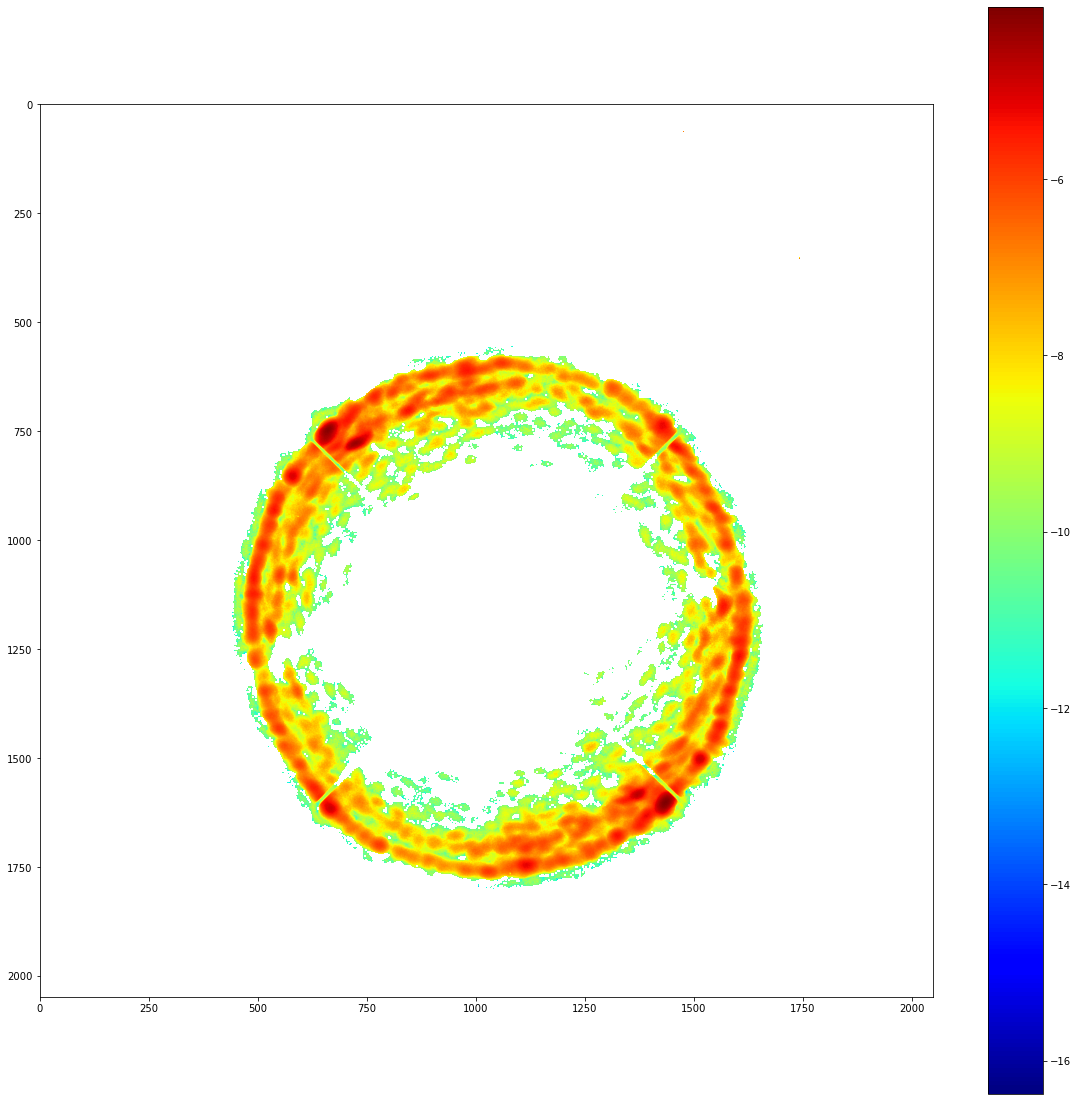

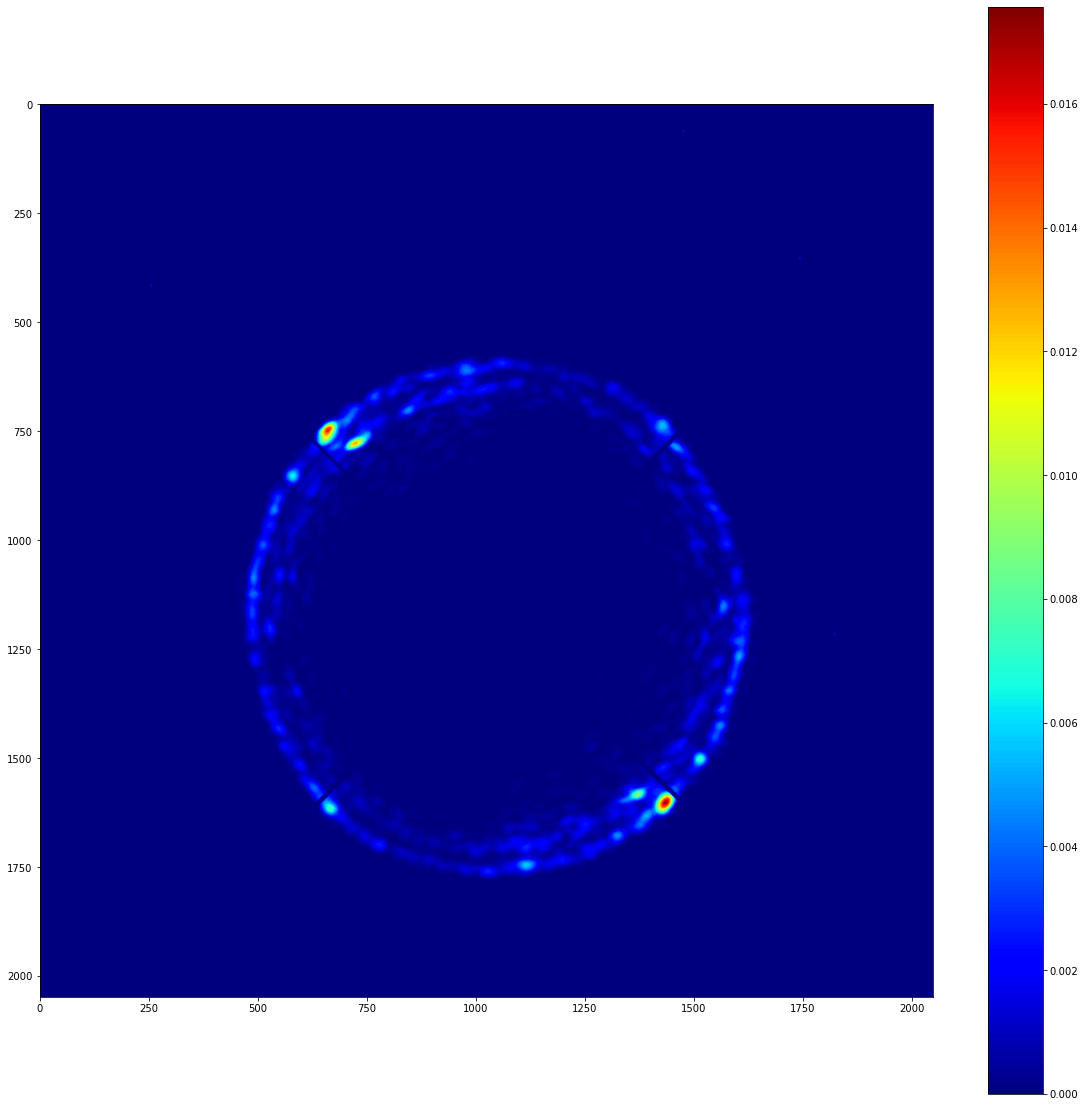

In [13]:
"""
Plot the azimuthal integration, with and without logs. Save the integration.
"""

utils.imshow(np.log(mean_bkg_in_clusters))
utils.imshow(mean_bkg_in_clusters)
# np.save("mean_bkg_in_clusters", mean_bkg_in_clusters)

/Users/richard/Documents/Code/work/i10_experiments/soliton_experiment/parsing_utils.py:178: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

/var/folders/91/cjqffvc108ddp27nm67npc000000gn/T/ipykernel_76222/1151224483.py:25: RuntimeWarning:

divide by zero encountered in log



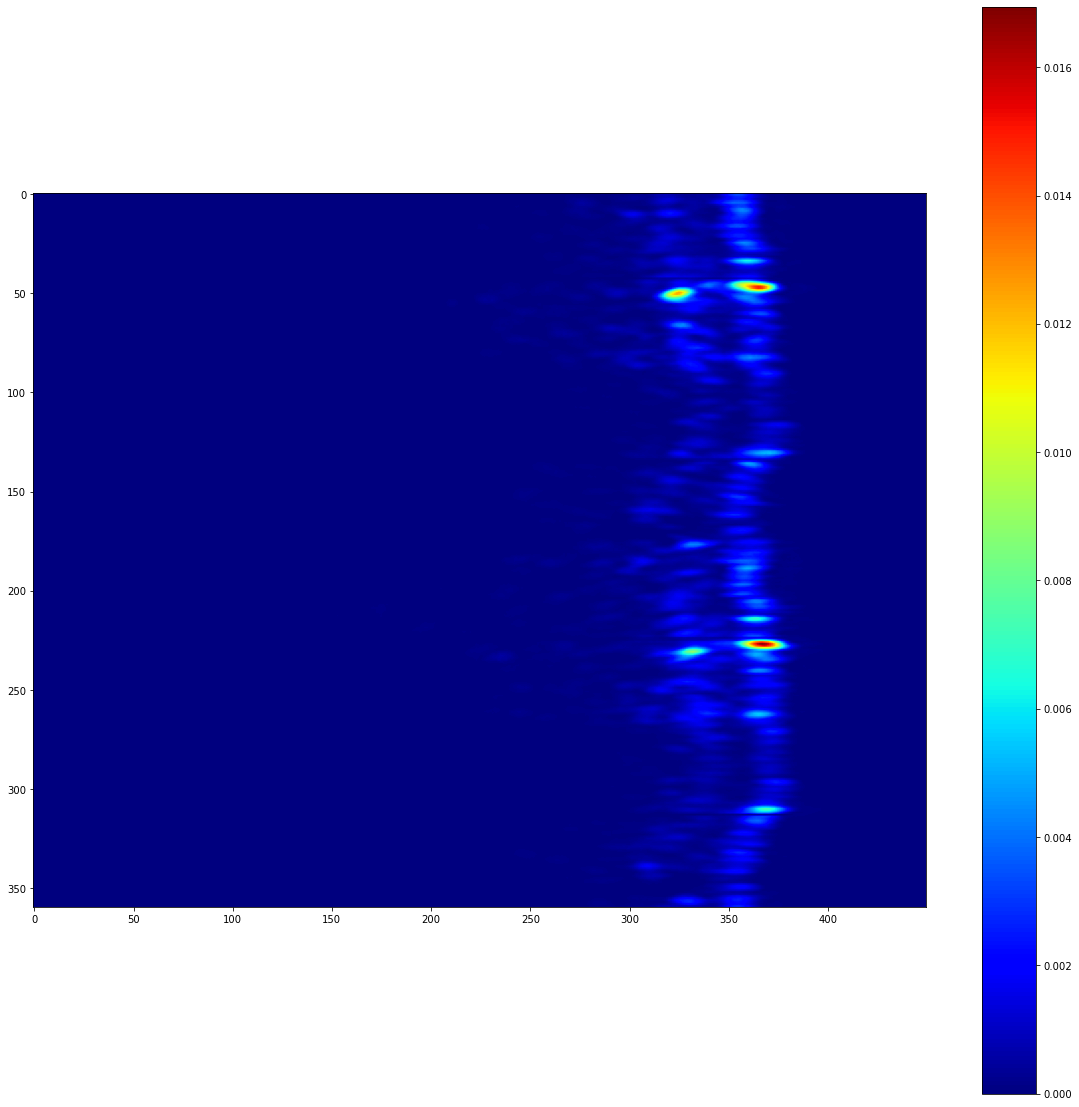

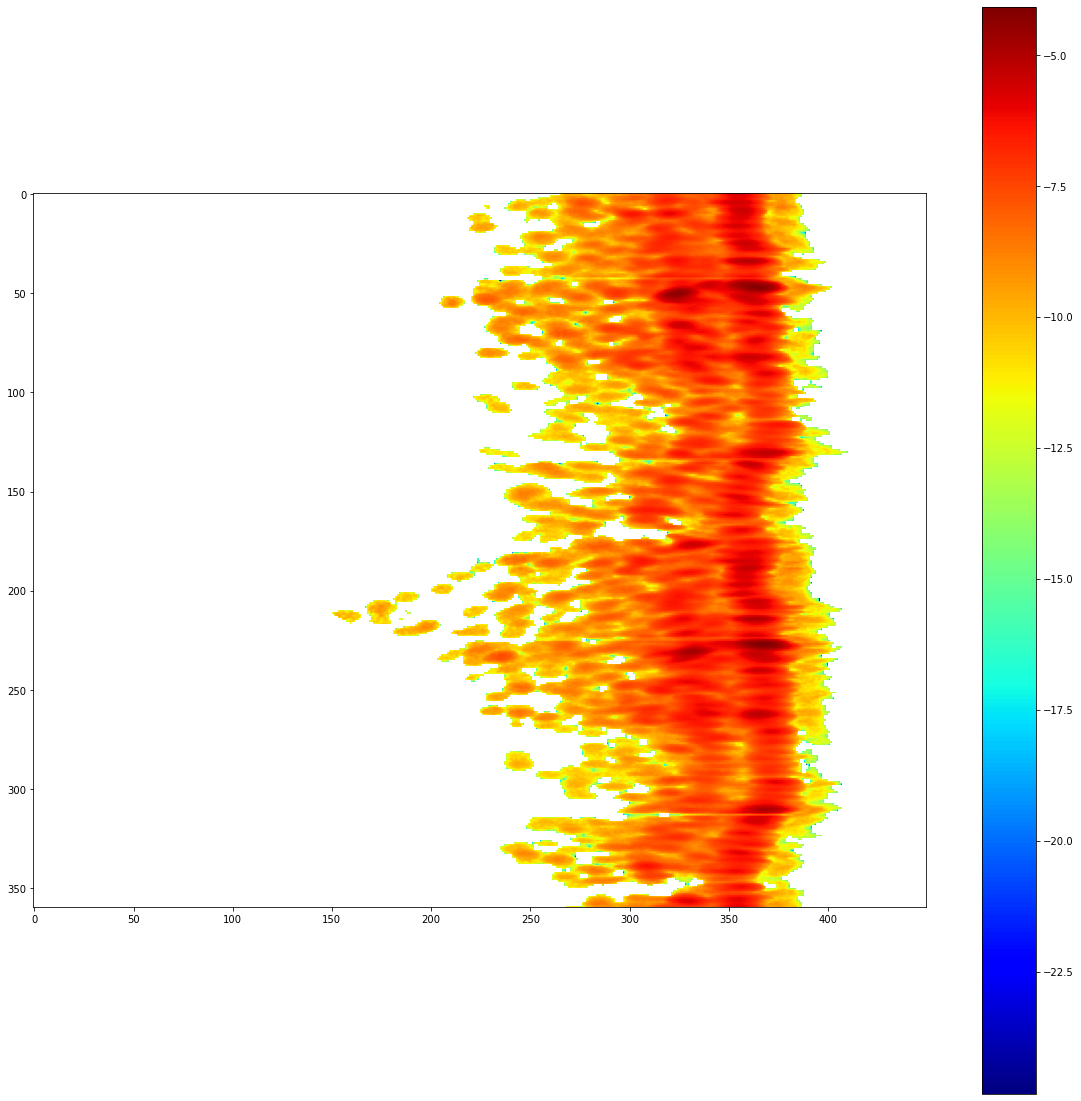

In [80]:
import pyFAI
import matplotlib.pyplot as plt
from pyFAI.gui import jupyter

importlib.reload(utils)

fai = pyFAI.load(utils.PONI_PATH)
result = fai.integrate1d(mean_bkg_in_clusters, 1000, mask=utils.OPEN_MASK)

# plt.plot(2*np.pi/result[0][100:], np.log(result[1][100:]+0.00000002))

result2d = fai.integrate2d_ng(mean_bkg_in_clusters,
                              1000, 360,
                              unit=pyFAI.units.Q,
                              filename="integrated_mean_bkg_in_clusters.edf")


# ax = jupyter.plot2d(result2d, color='jet')

k_ticks = [str(x) for x in result[0][:450]]

# utils.imshow(result2d.intensity[:, :450])
# print(result2d.intensity[:, :450].shape)
utils.imshow(result2d.intensity[:, :450])
utils.imshow(np.log(result2d.intensity[:, :450]))


In [81]:
"""
Now do the above, but as a function of field.
"""

all_clusters = {1.5*x: [] for x in range(len(utils.SCAN_DIRS))}
bkg_in_clusters_per_field = [
    np.zeros_like(utils.get_rough_background(utils.SCAN_DIRS[0]))
    for x in range(30)
]

for field in range(30):
    for angle in np.arange(0, 180, 1.5):
        print(f"Angle: {angle} deg, field: {field} mT")
        # First subtract the background and add the bkg subbed data to the
        # averaged_total_bkg_subbed_images array.
        tiff = utils.get_tiff_angle_field(angle, field)
        bkg = utils.get_rough_background_angle(angle)
        img = ccd.CCDImage(tiff, bkg, utils.MASK, utils.METADATA)
        img.subtract_bkg()
        bkg_subbed_data = np.copy(img.data)

        # Now do clustering.
        clusters = img.cluster_significant_pixels(utils.SIGNAL_LENGTH_SCALE,
                                                  utils.BKG_LENGTH_SCALE)

        # Save the clusters, so I don't have to keep redoing this calculation.
        all_clusters[angle].append(clusters)

        cluster_mask = img.mask_from_clusters(clusters)
        # Only look at bkg_subbed_data that's clustered and significant.
        bkg_in_clusters = bkg_subbed_data * cluster_mask
        bkg_in_clusters_per_field[field] += bkg_in_clusters



Angle: 0.0 deg, field: 0 mT
Angle: 1.5 deg, field: 0 mT
Angle: 3.0 deg, field: 0 mT
Angle: 4.5 deg, field: 0 mT
Angle: 6.0 deg, field: 0 mT
Angle: 7.5 deg, field: 0 mT
Angle: 9.0 deg, field: 0 mT
Angle: 10.5 deg, field: 0 mT
Angle: 12.0 deg, field: 0 mT
Angle: 13.5 deg, field: 0 mT
Angle: 15.0 deg, field: 0 mT
Angle: 16.5 deg, field: 0 mT
Angle: 18.0 deg, field: 0 mT
Angle: 19.5 deg, field: 0 mT
Angle: 21.0 deg, field: 0 mT
Angle: 22.5 deg, field: 0 mT
Angle: 24.0 deg, field: 0 mT
Angle: 25.5 deg, field: 0 mT
Angle: 27.0 deg, field: 0 mT
Angle: 28.5 deg, field: 0 mT
Angle: 30.0 deg, field: 0 mT
Angle: 31.5 deg, field: 0 mT
Angle: 33.0 deg, field: 0 mT
Angle: 34.5 deg, field: 0 mT
Angle: 36.0 deg, field: 0 mT
Angle: 37.5 deg, field: 0 mT
Angle: 39.0 deg, field: 0 mT
Angle: 40.5 deg, field: 0 mT
Angle: 42.0 deg, field: 0 mT
Angle: 43.5 deg, field: 0 mT
Angle: 45.0 deg, field: 0 mT
Angle: 46.5 deg, field: 0 mT
Angle: 48.0 deg, field: 0 mT
Angle: 49.5 deg, field: 0 mT
Angle: 51.0 deg, fiel

/Users/richard/Documents/Code/work/i10_experiments/soliton_experiment/parsing_utils.py:178: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

/Users/richard/Documents/Code/work/i10_experiments/soliton_experiment/parsing_utils.py:174: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



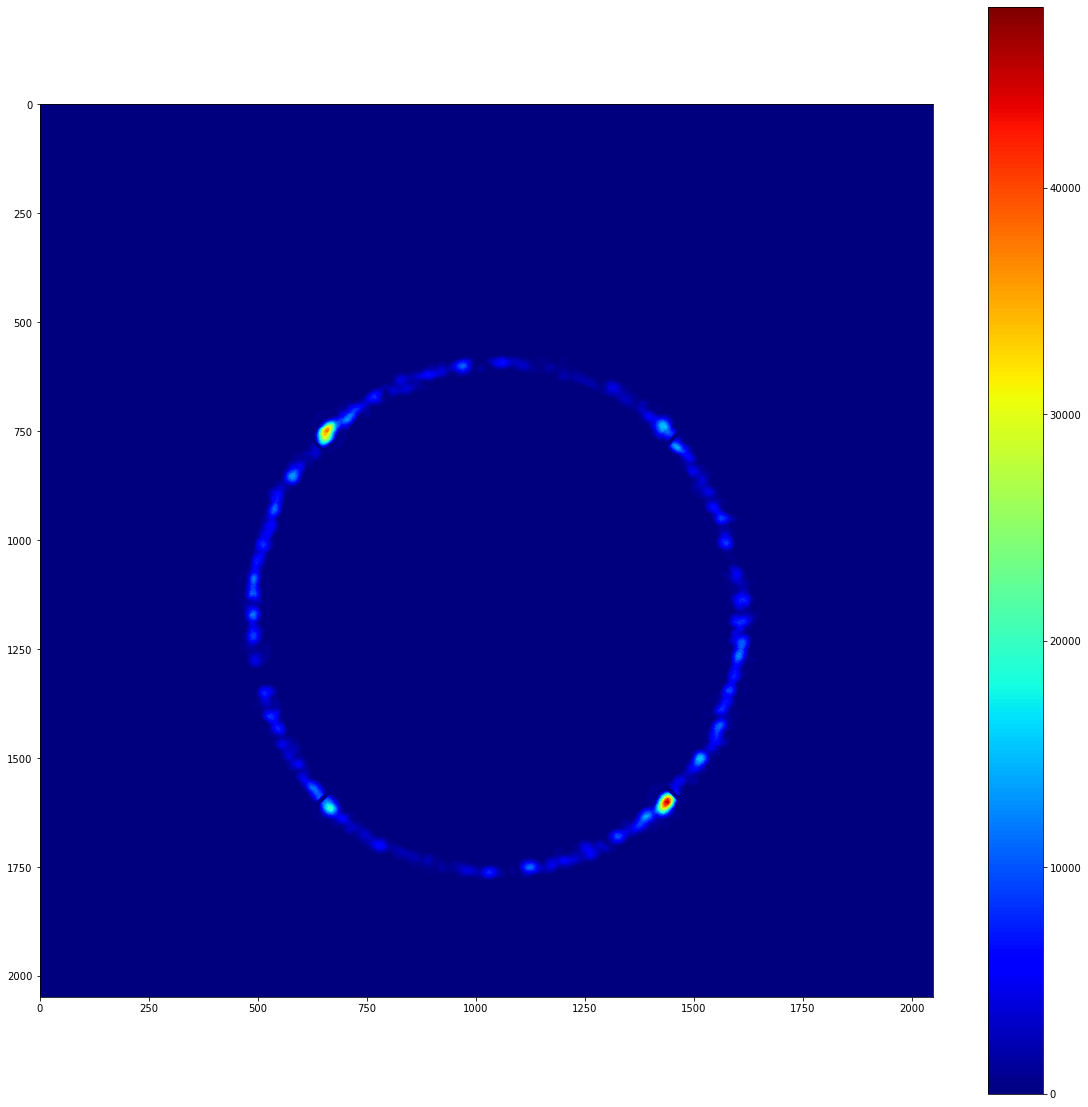

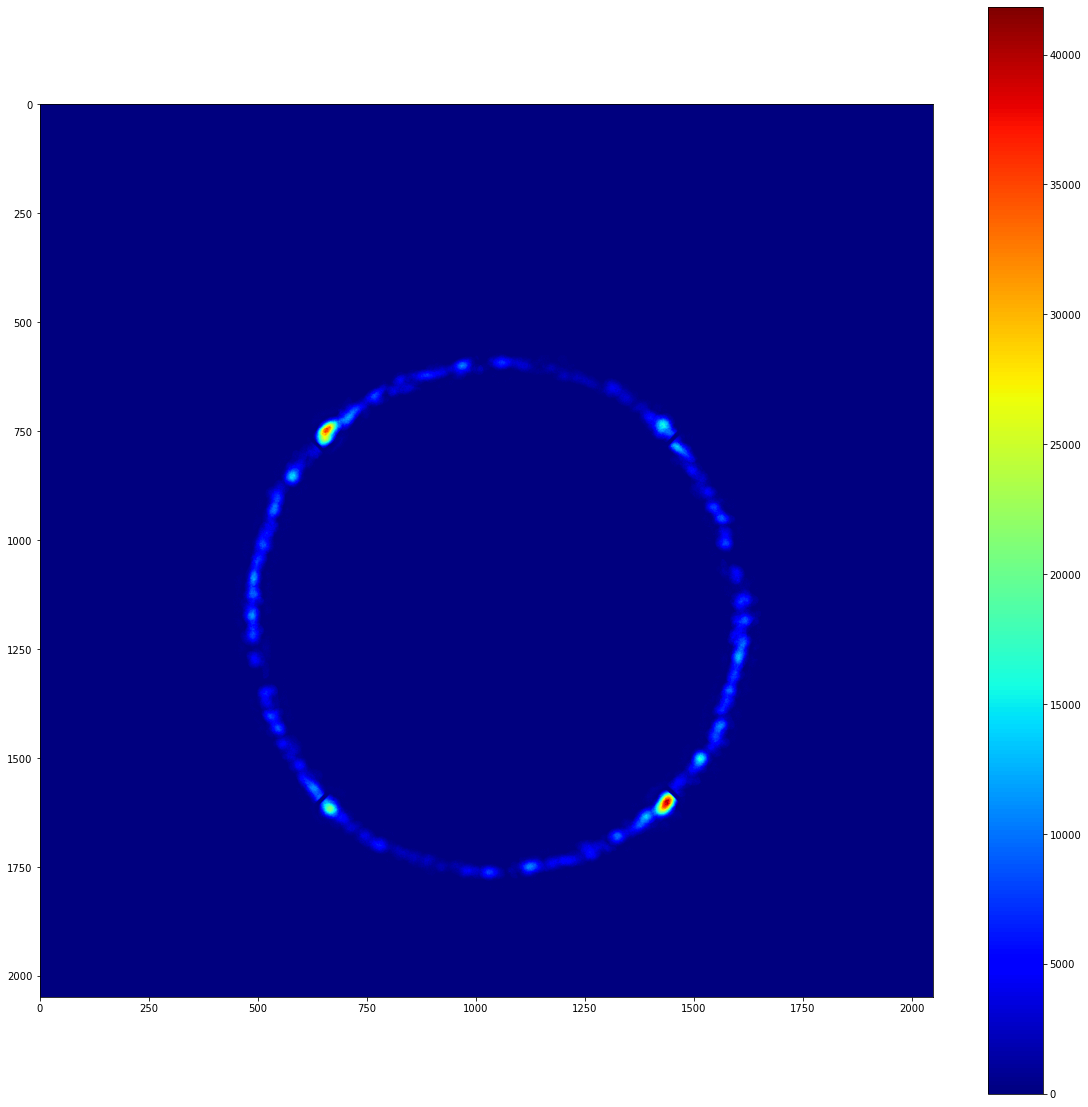

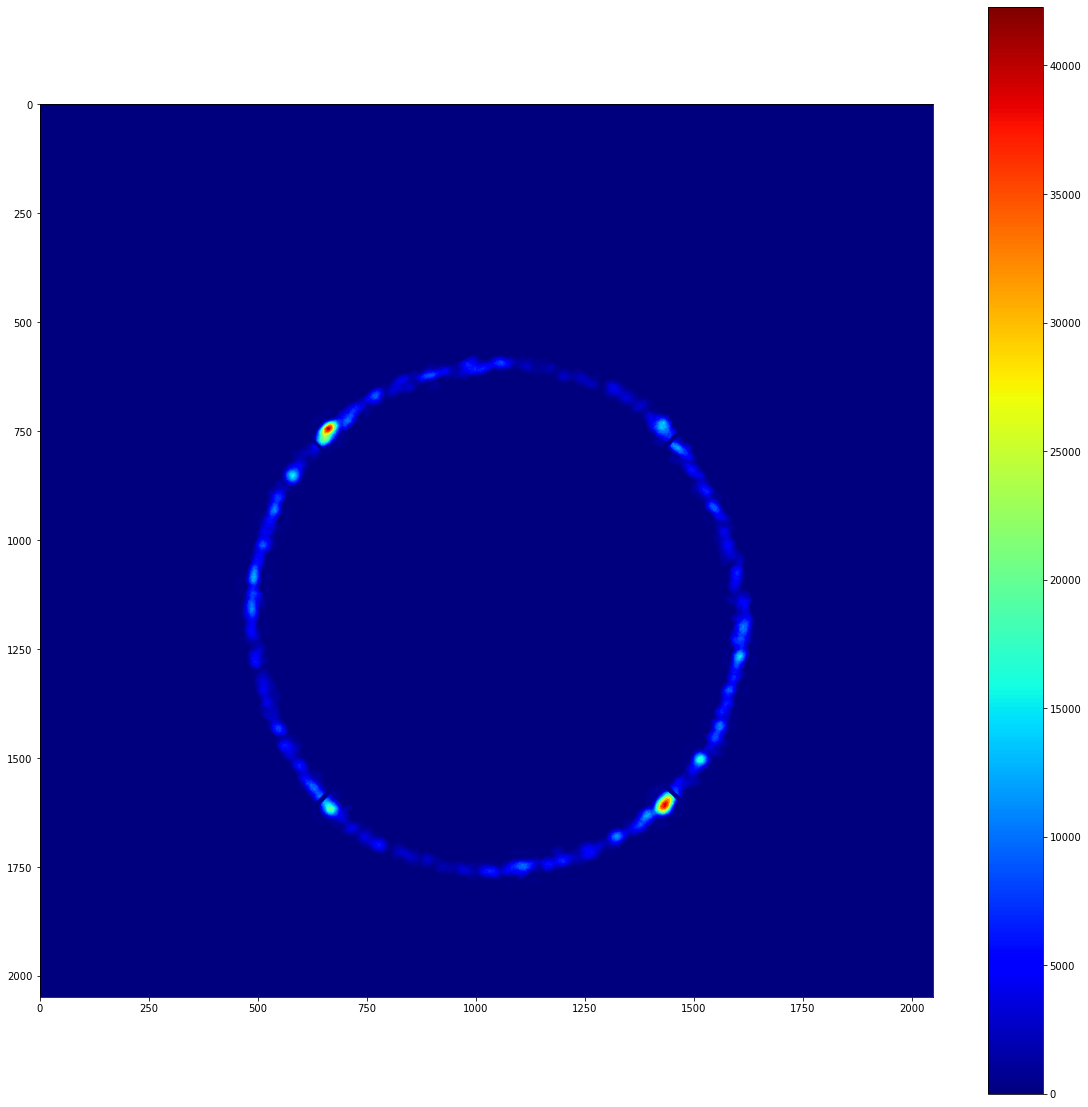

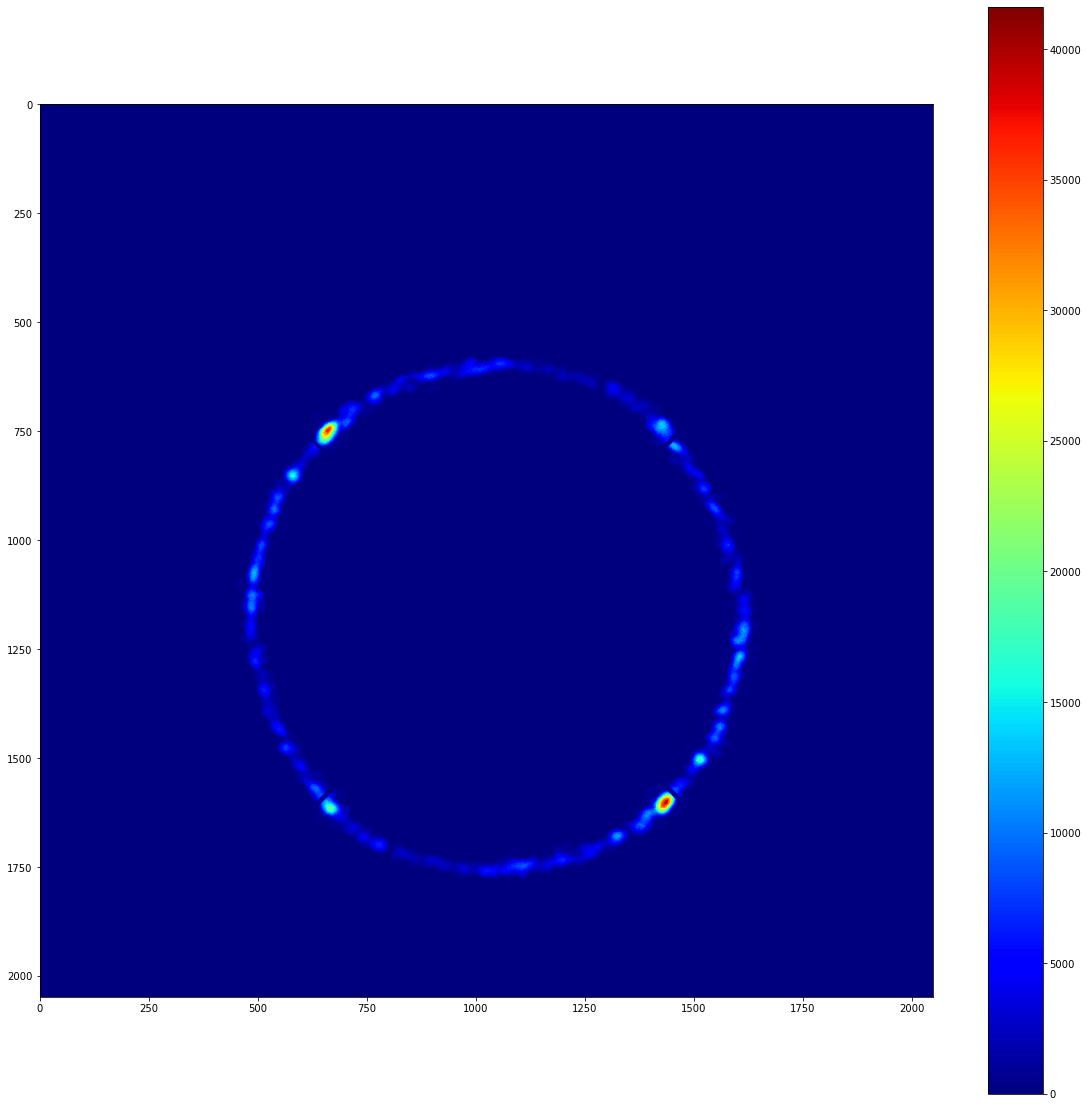

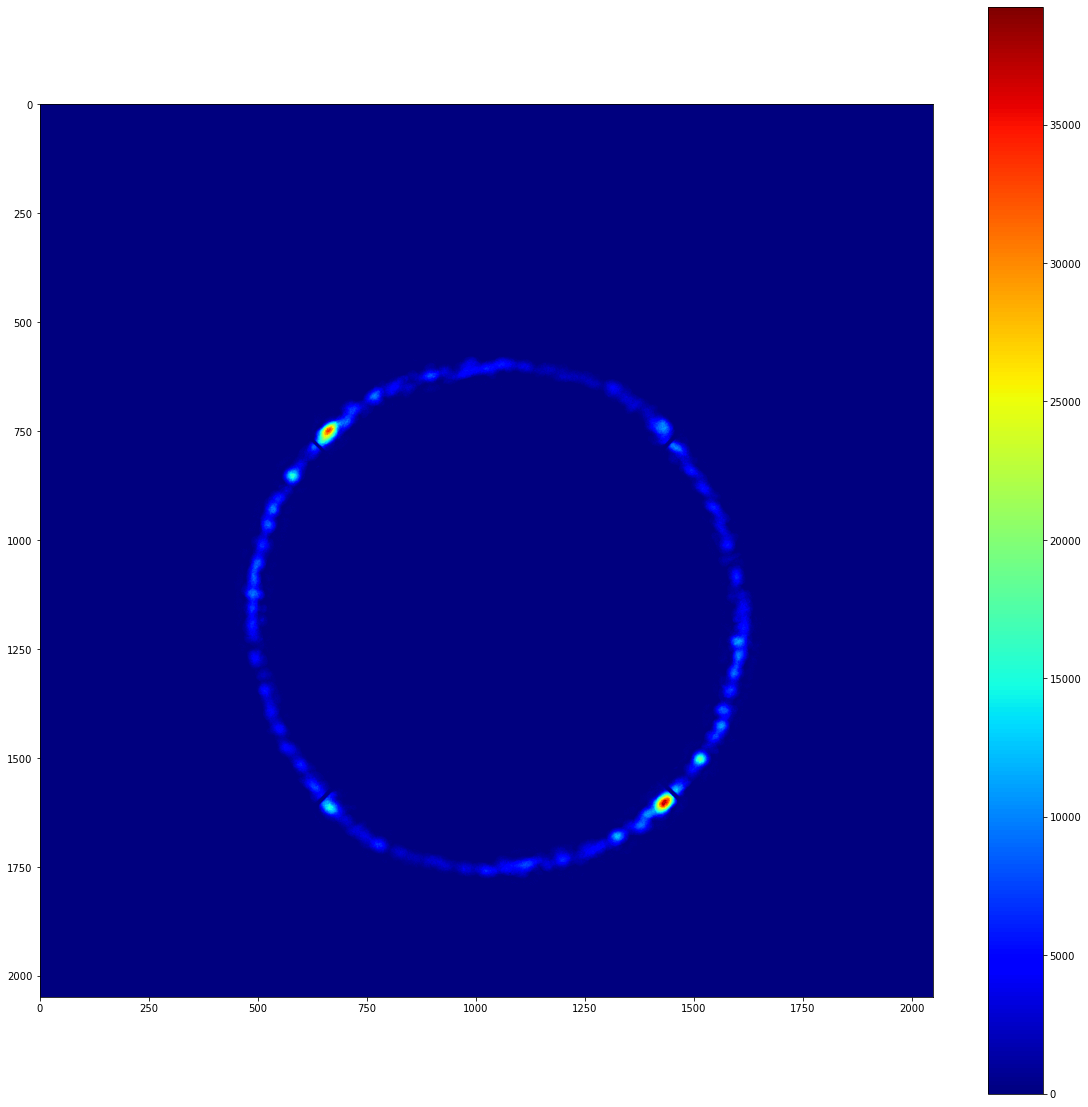

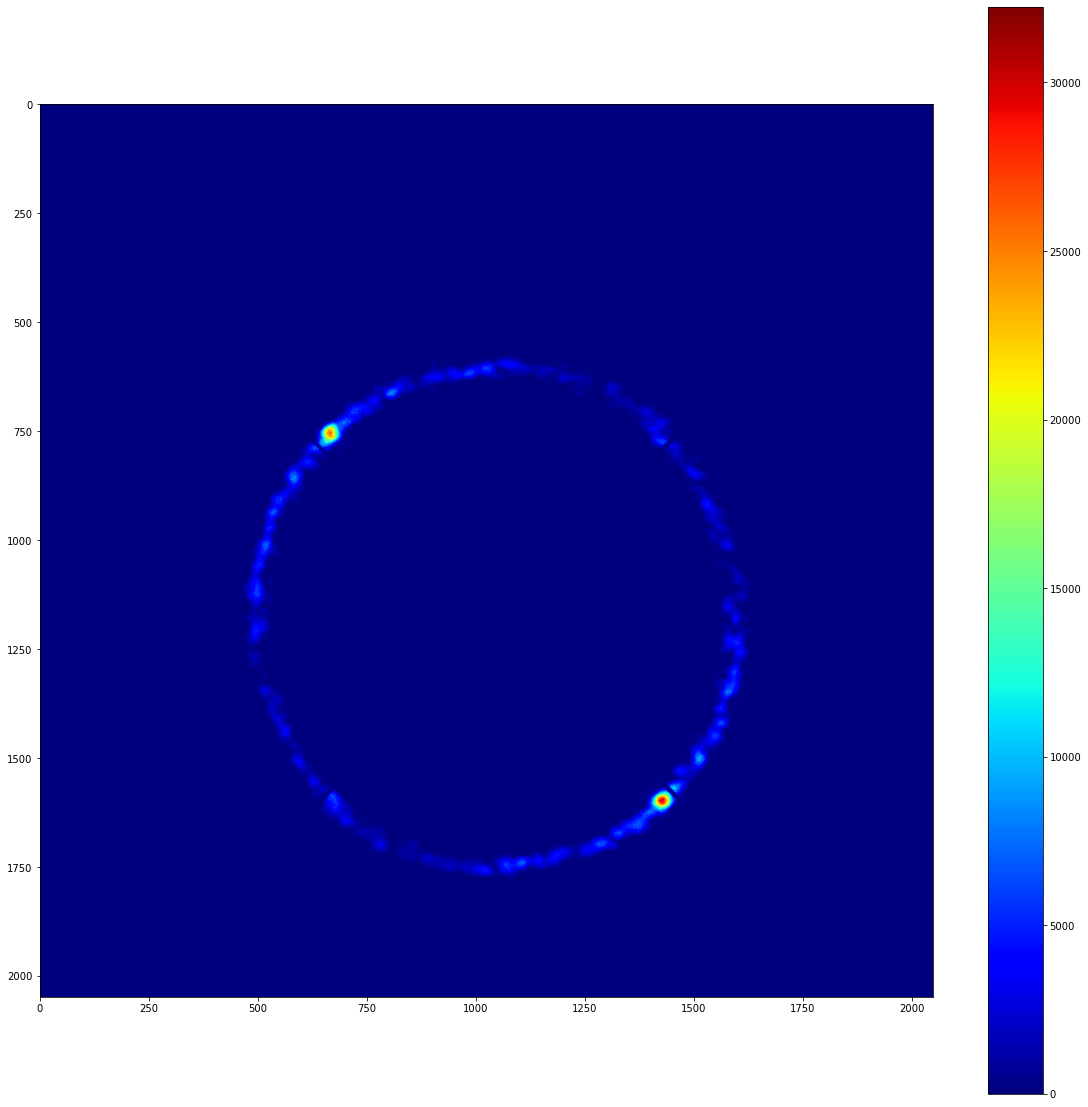

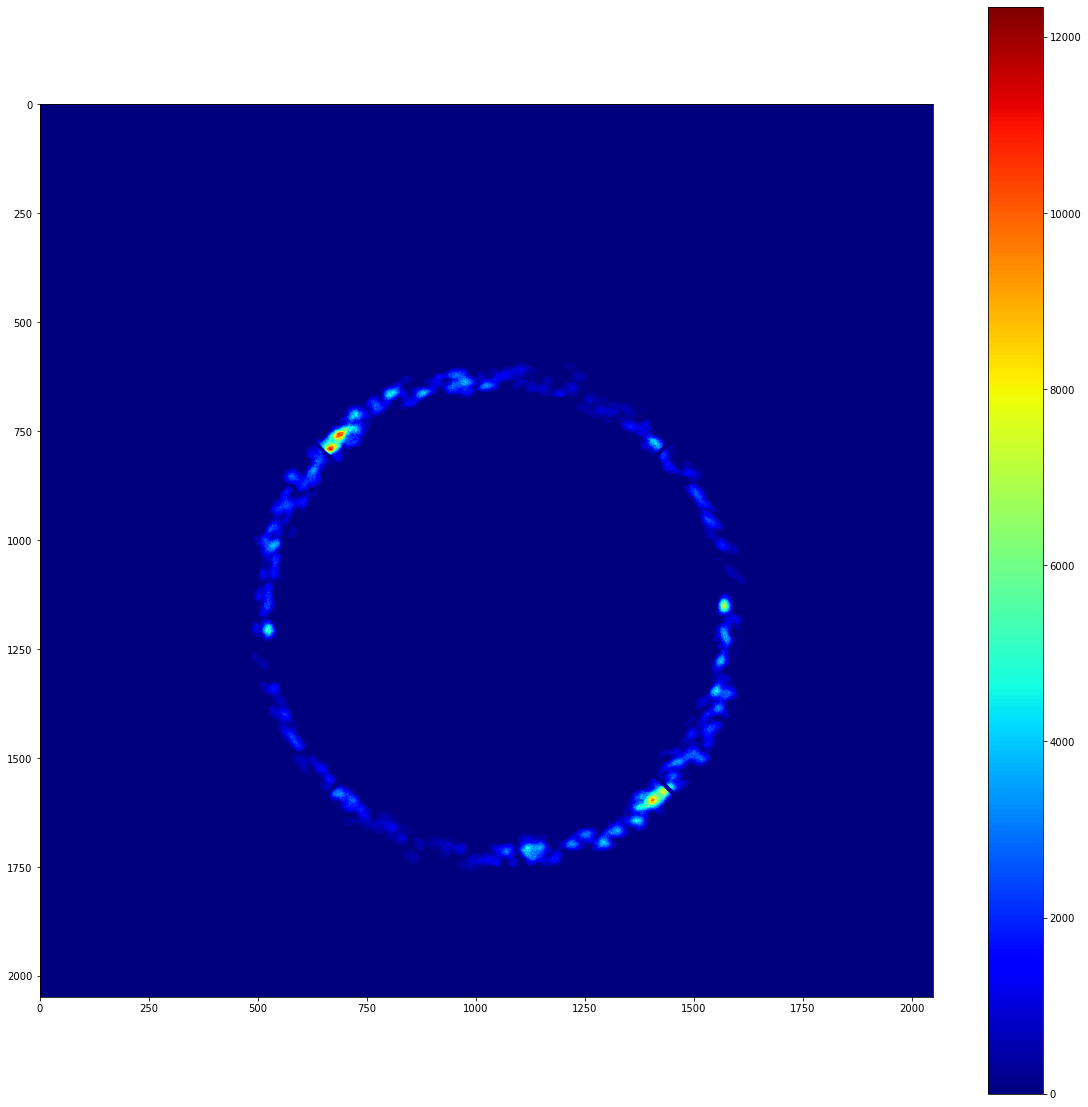

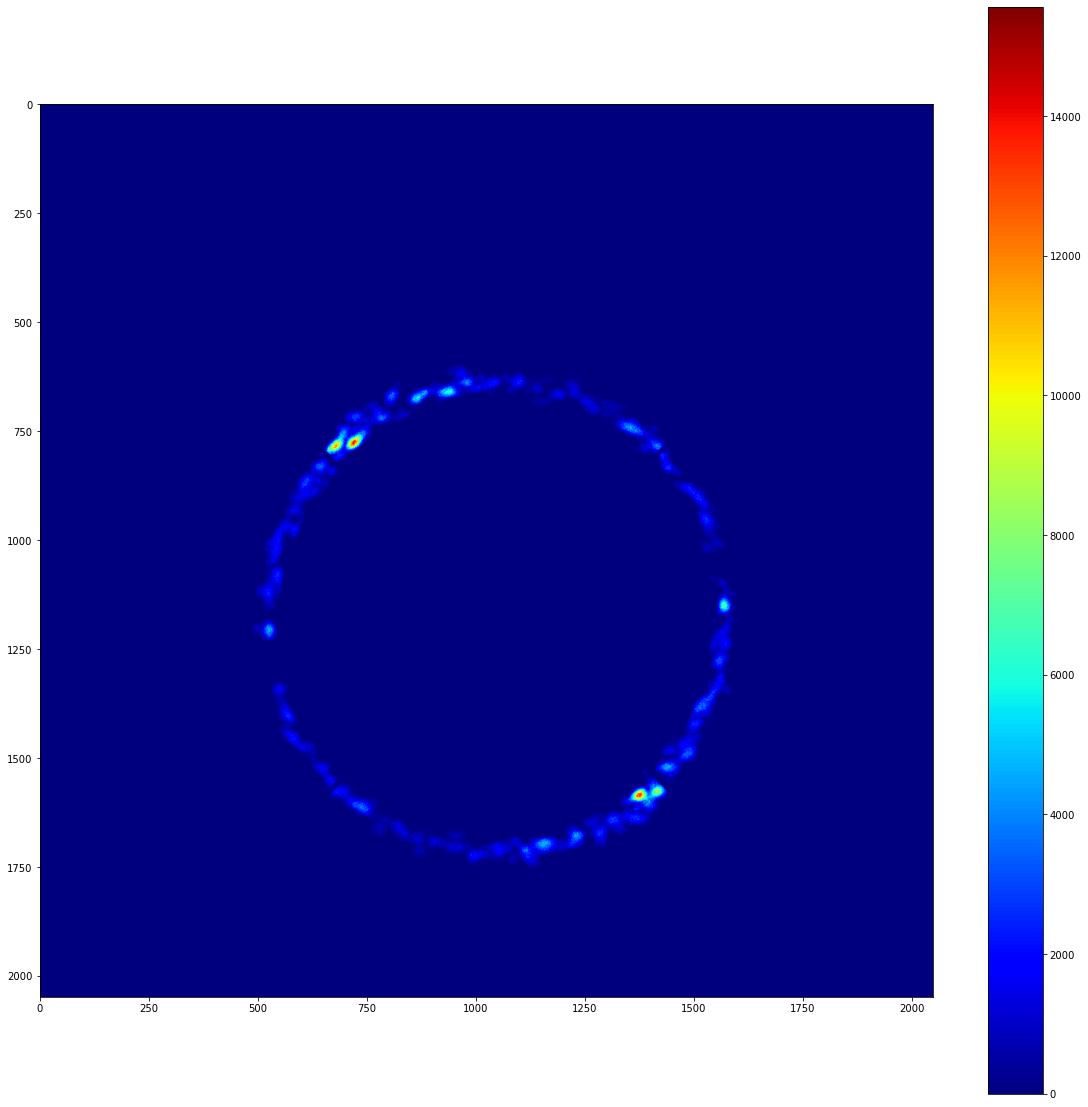

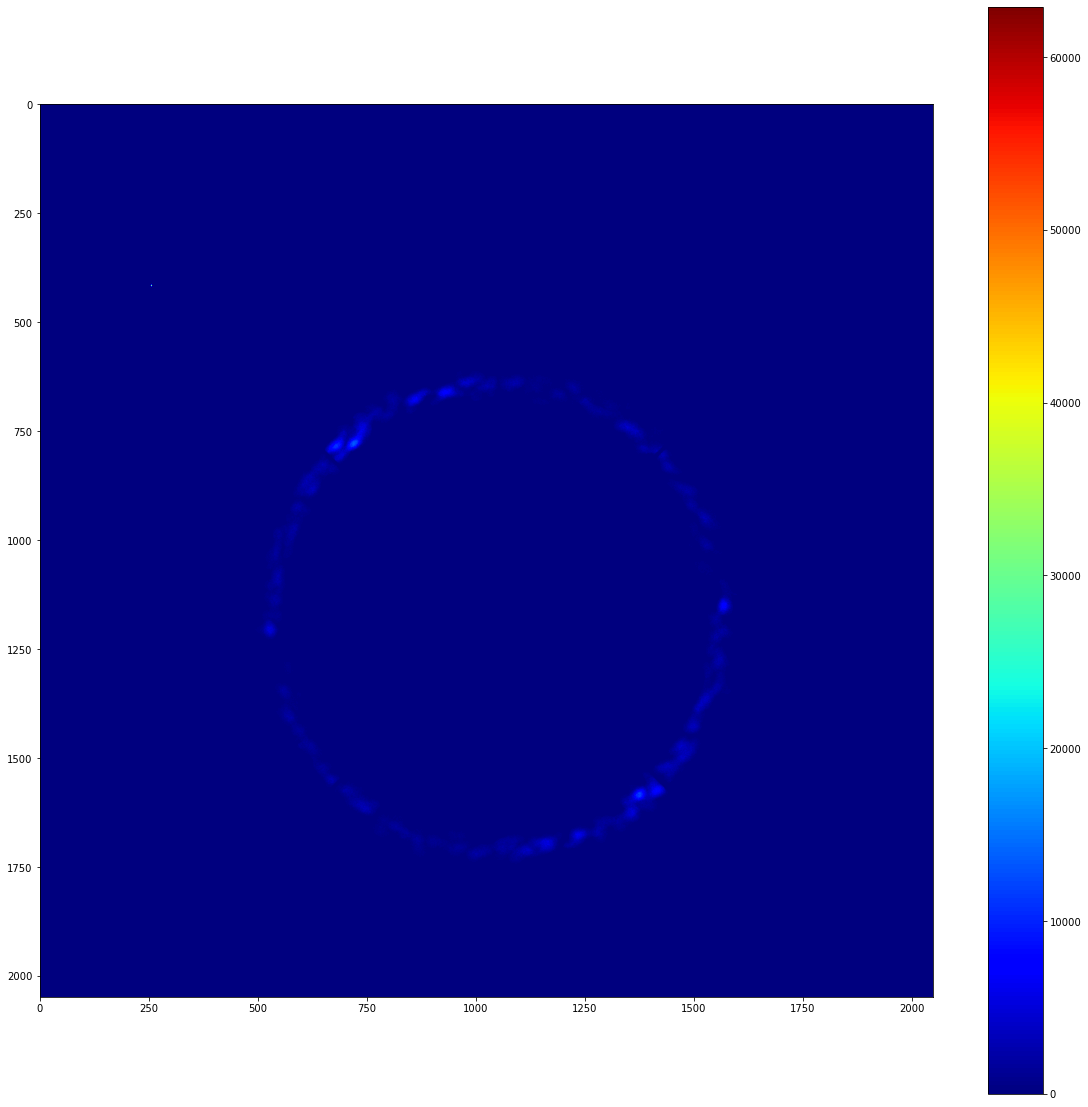

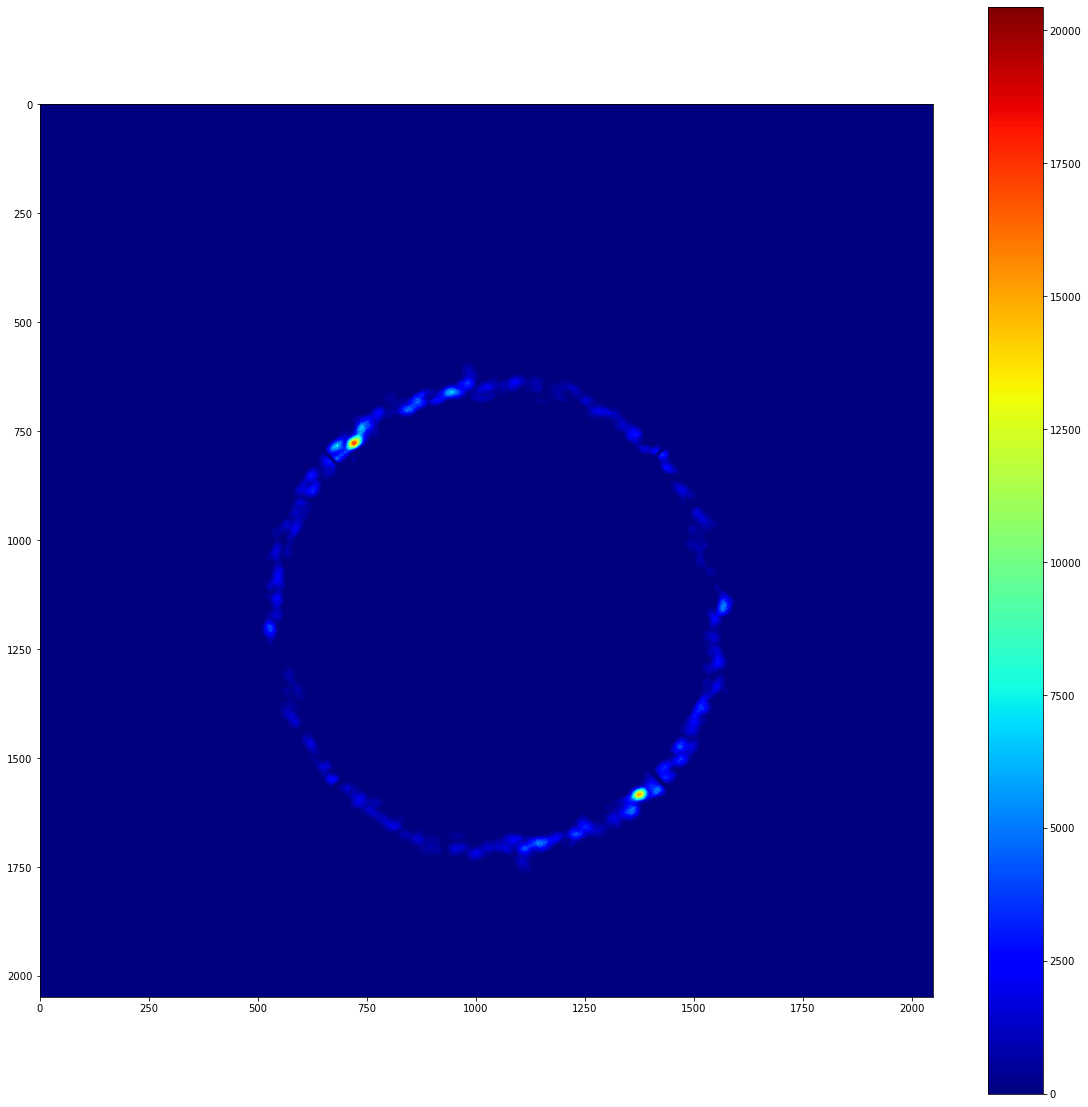

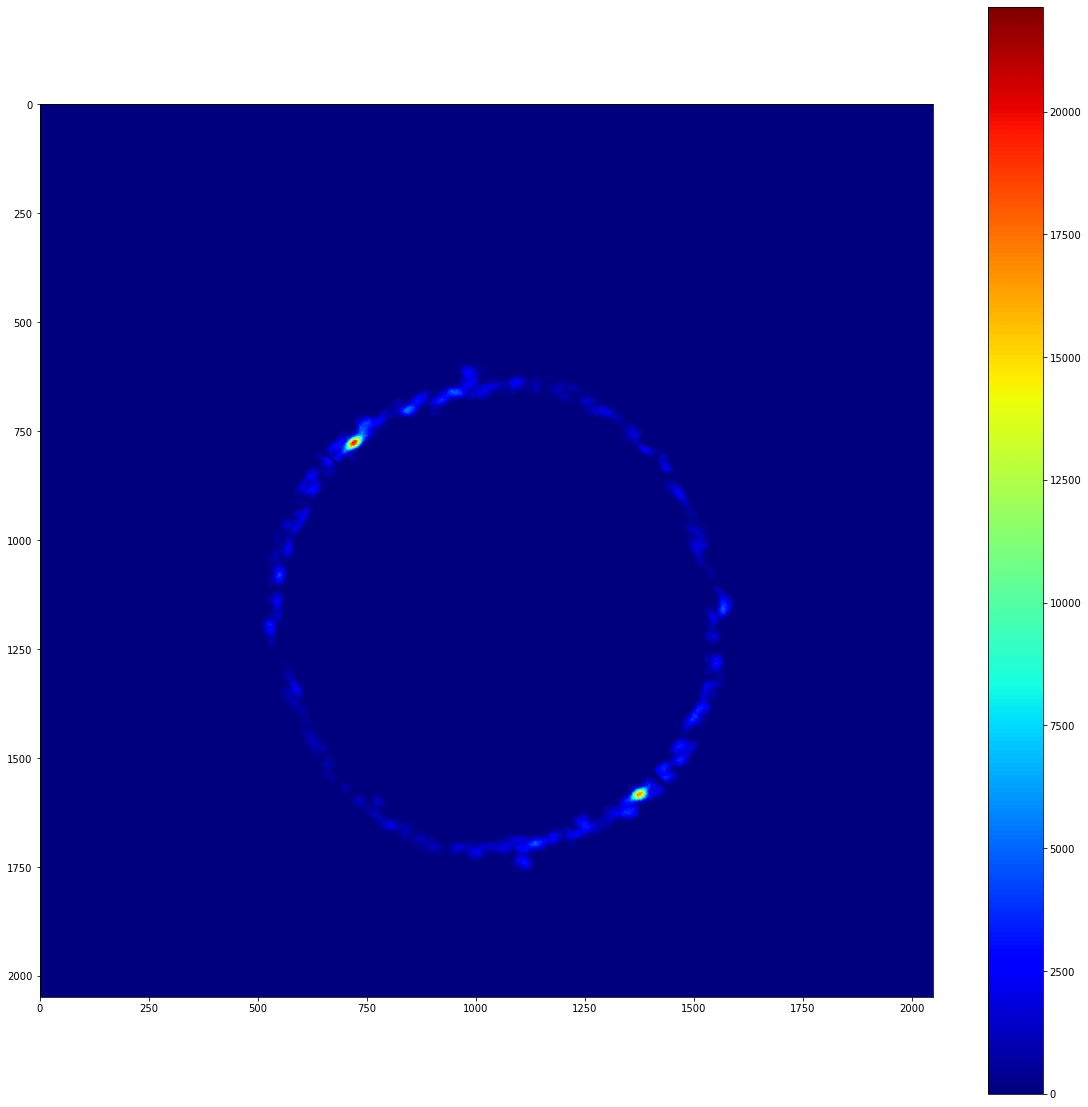

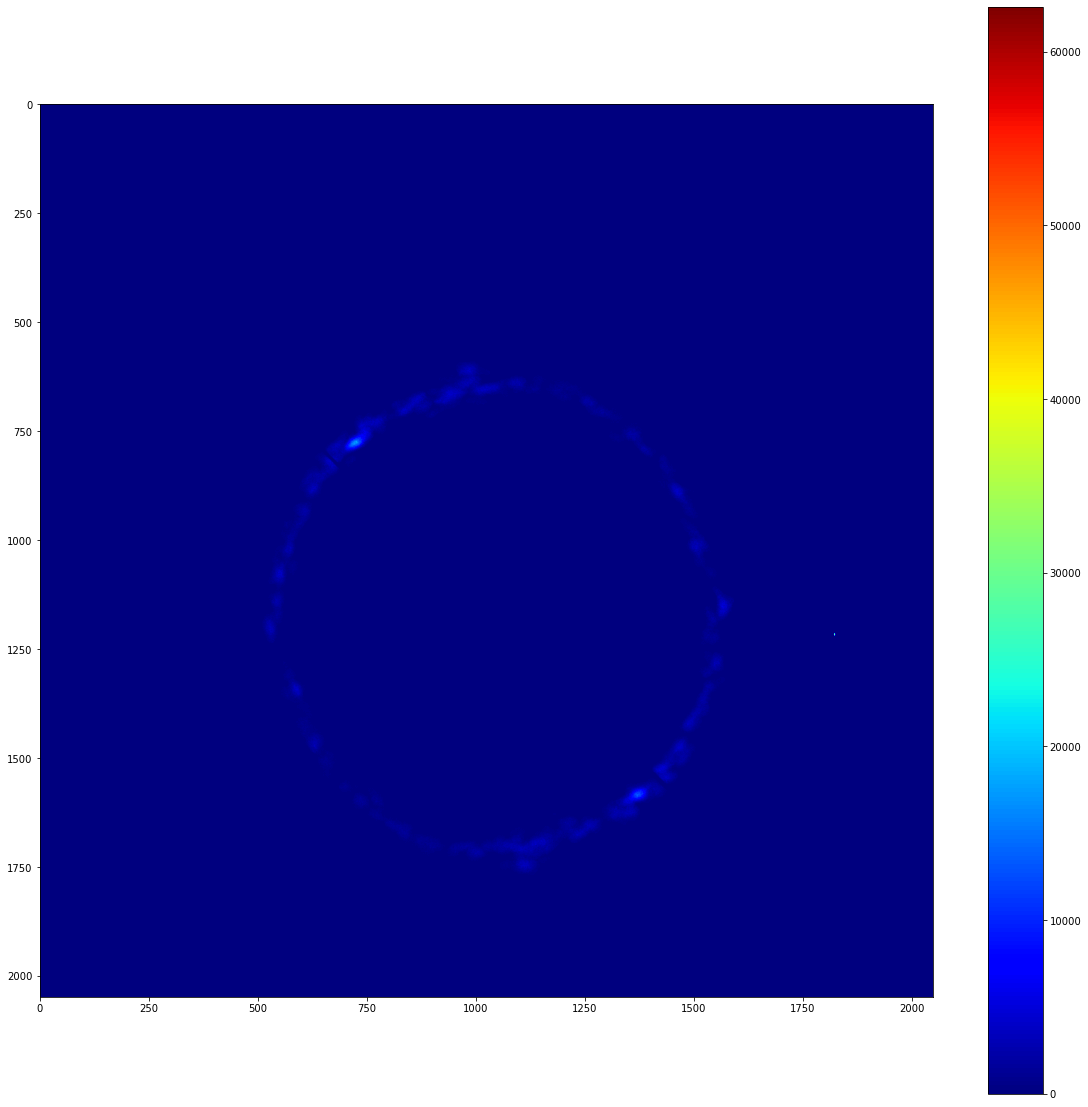

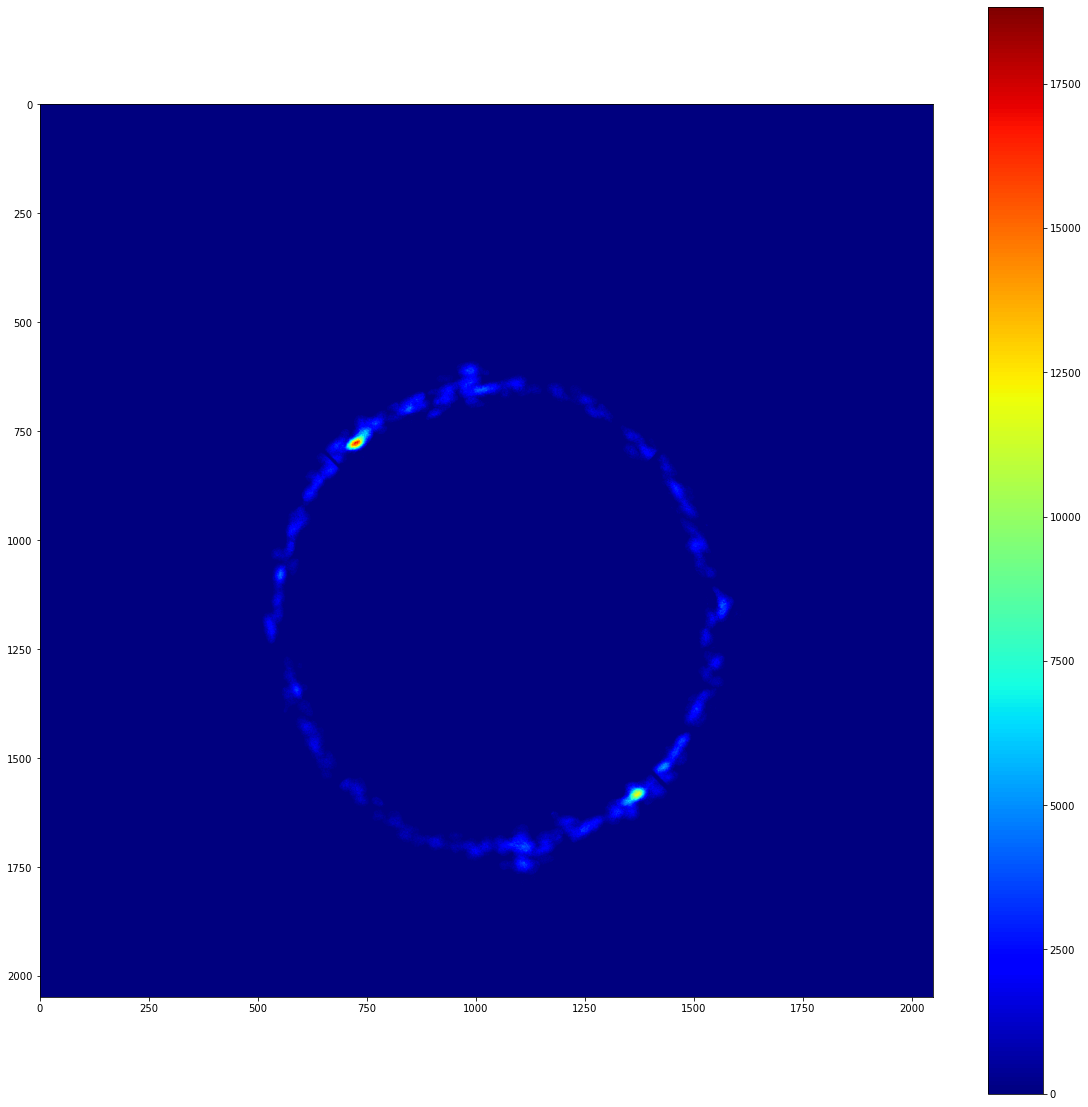

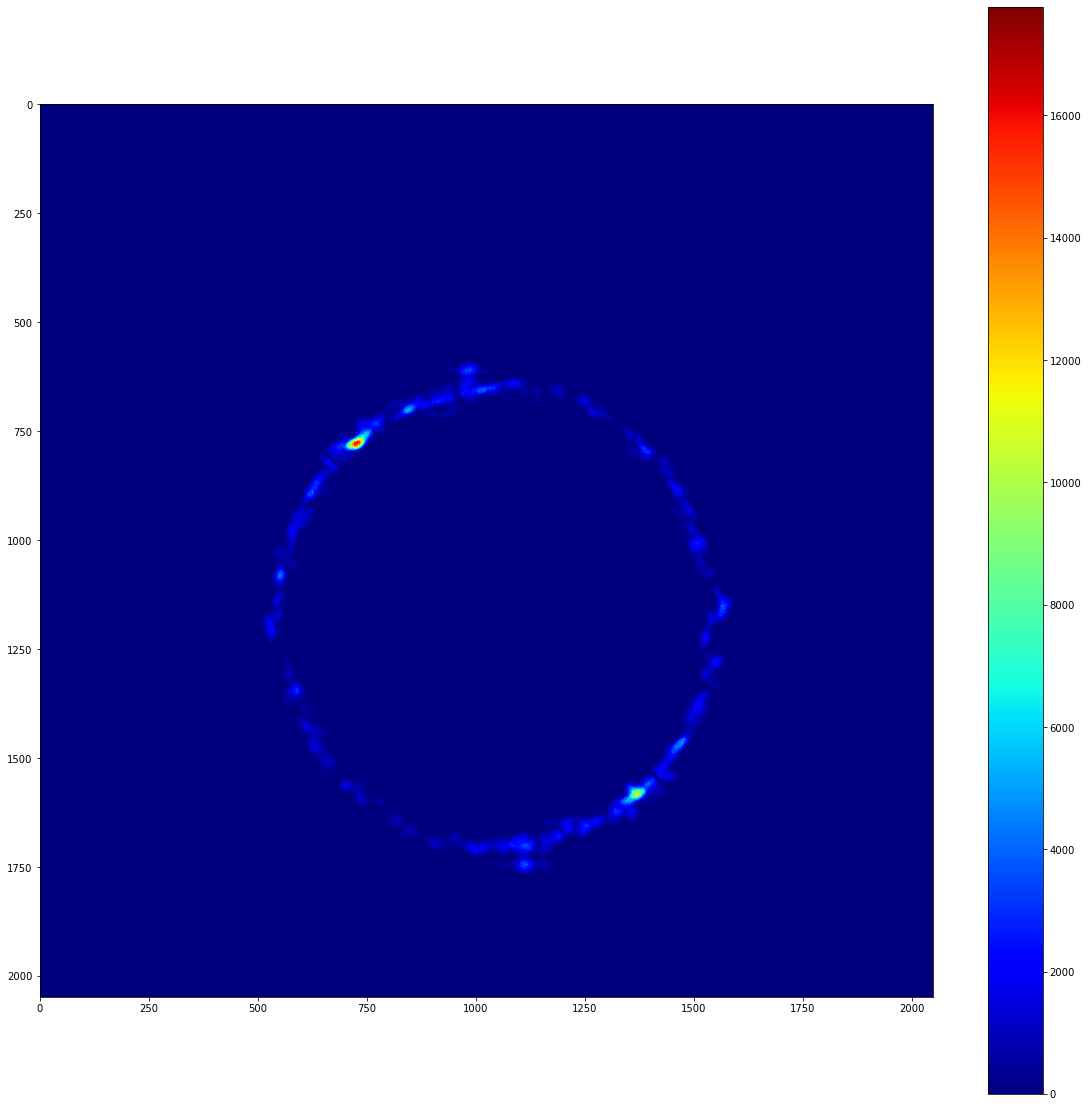

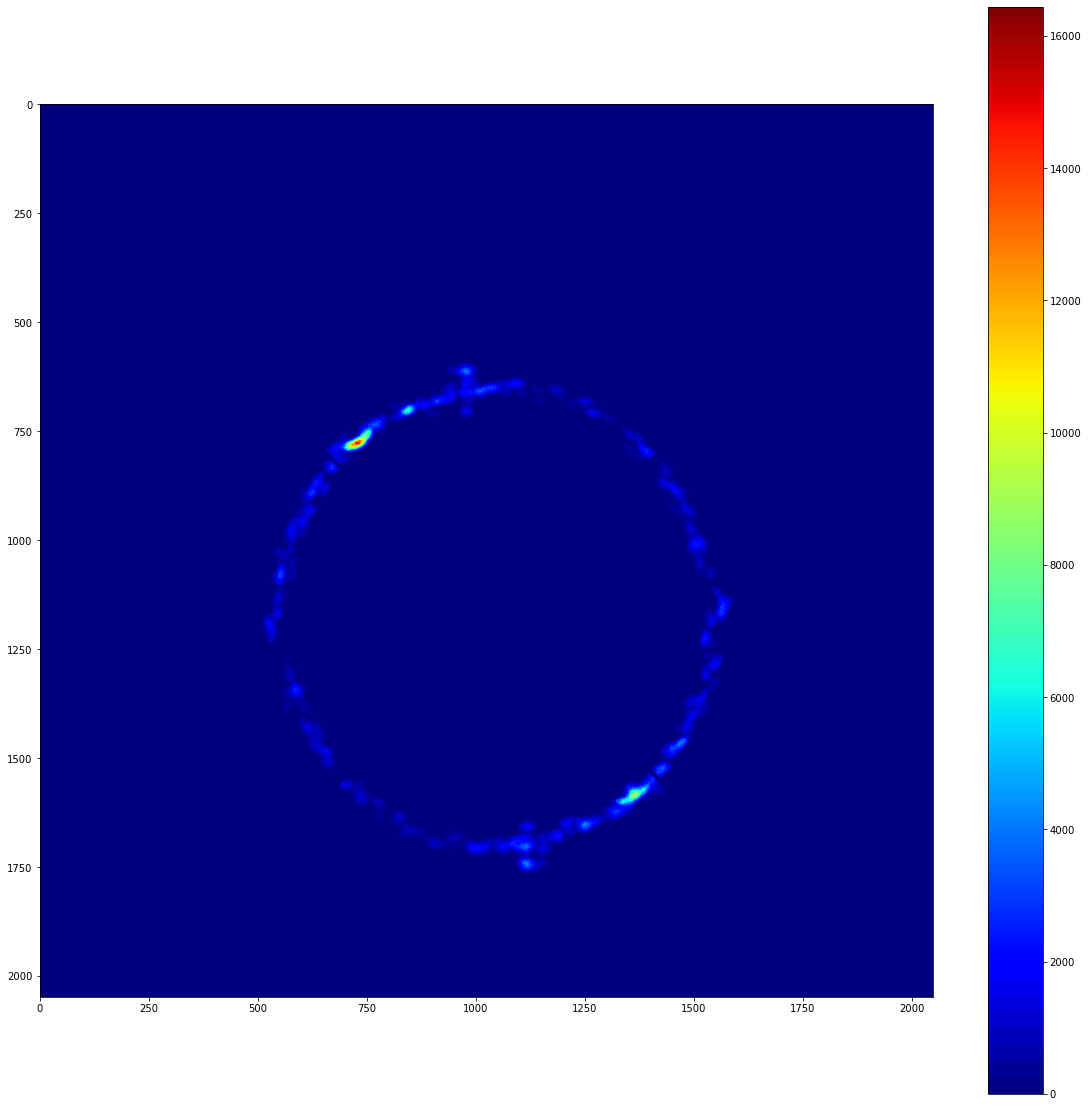

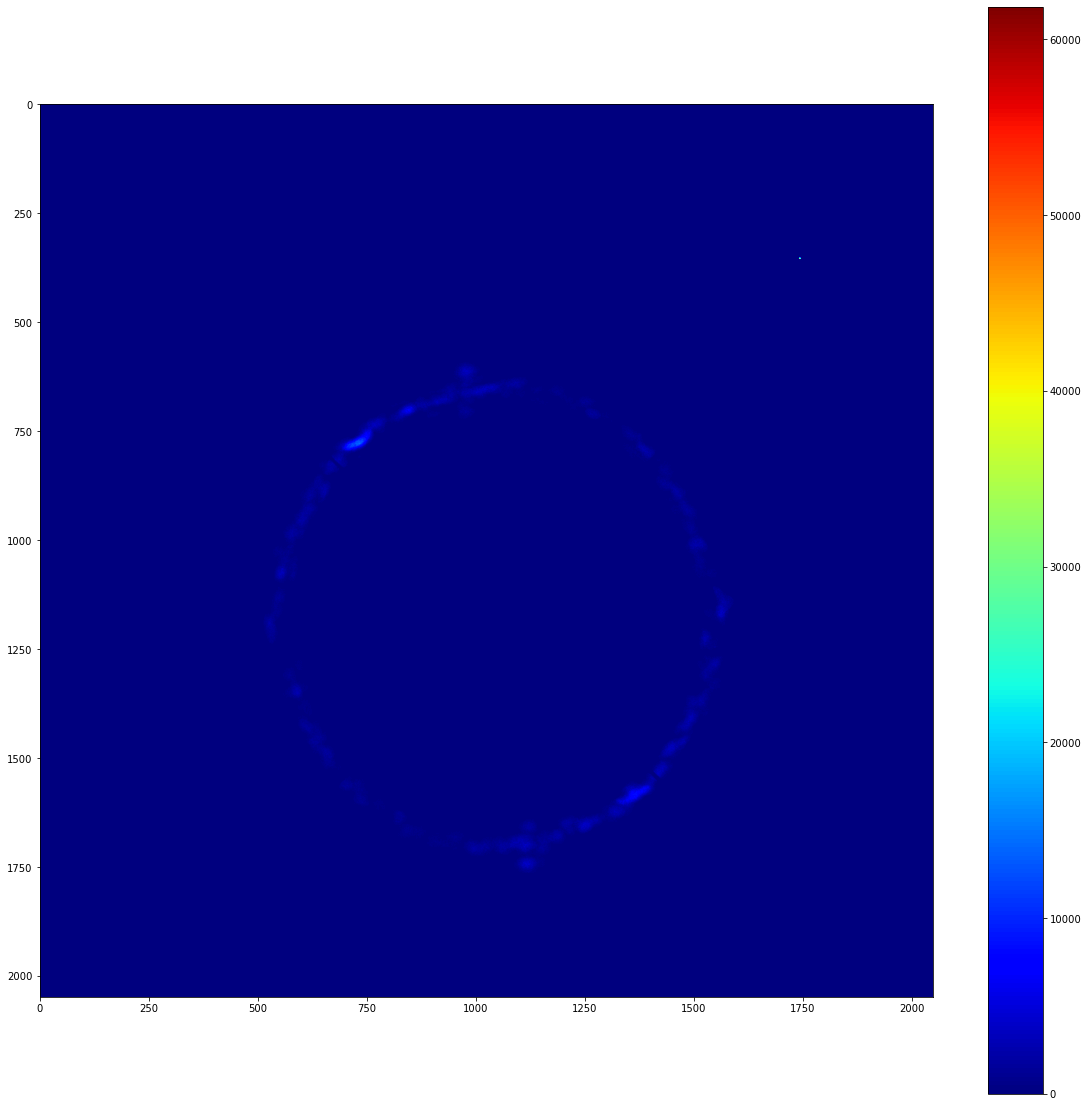

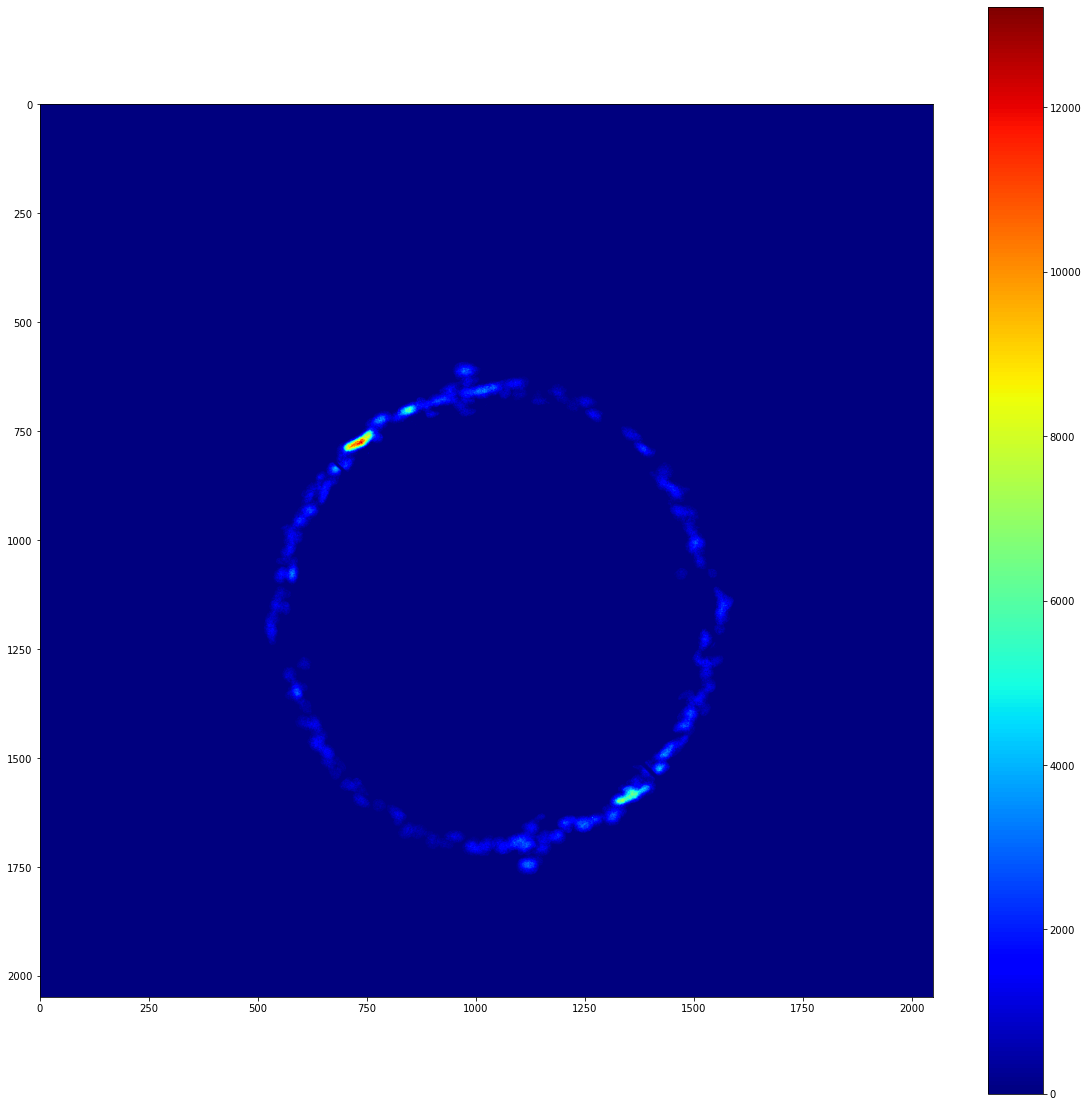

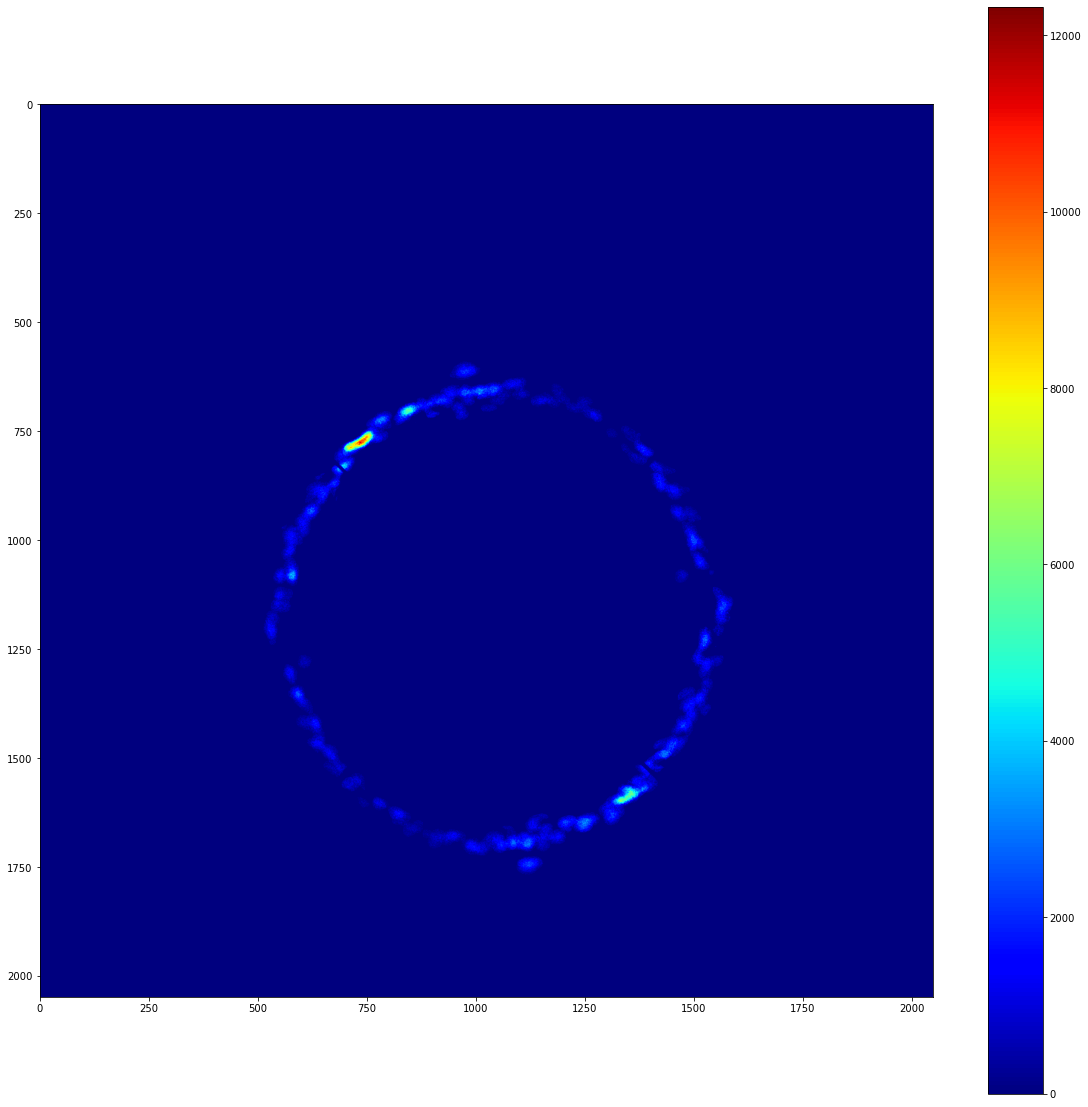

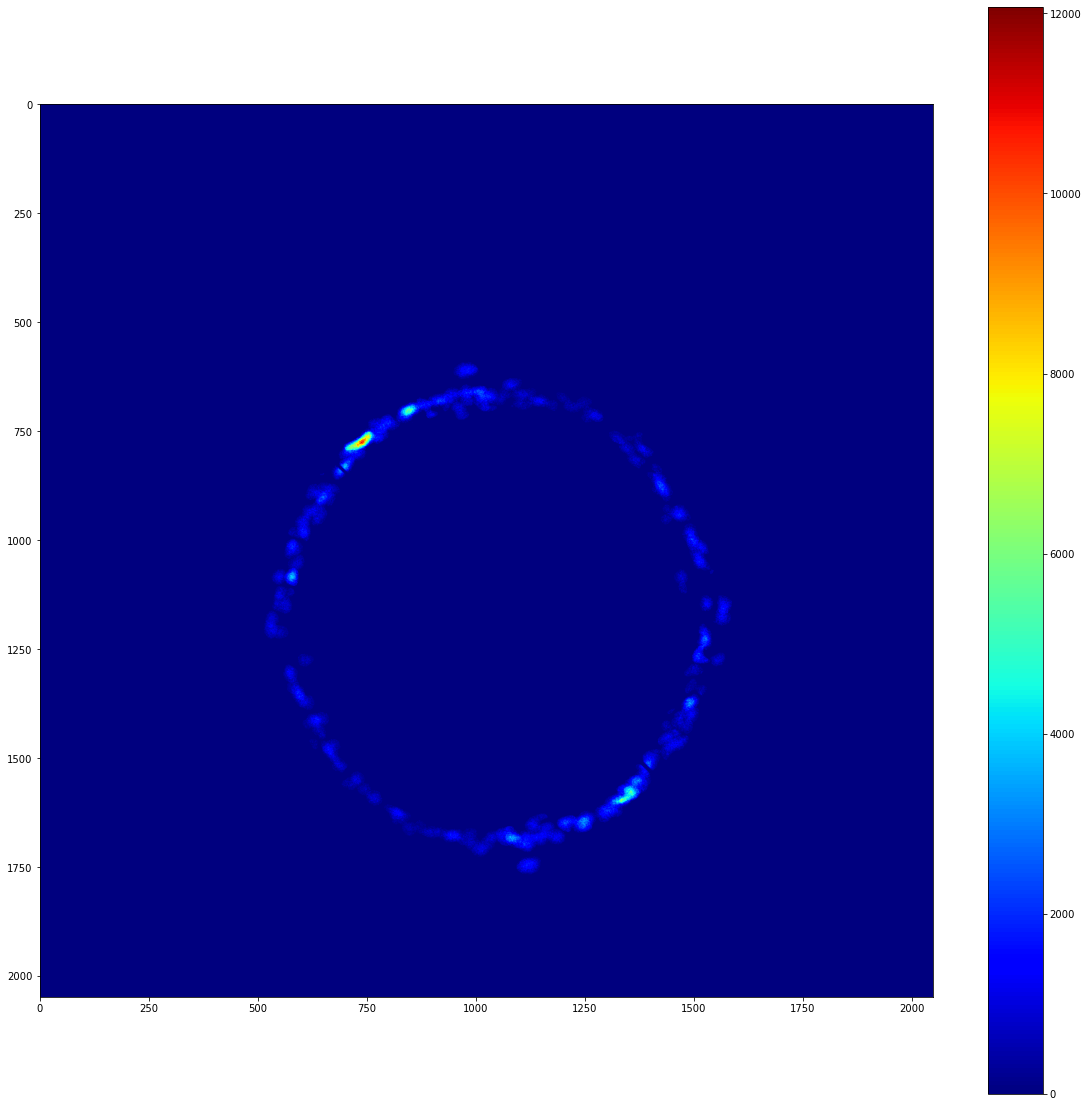

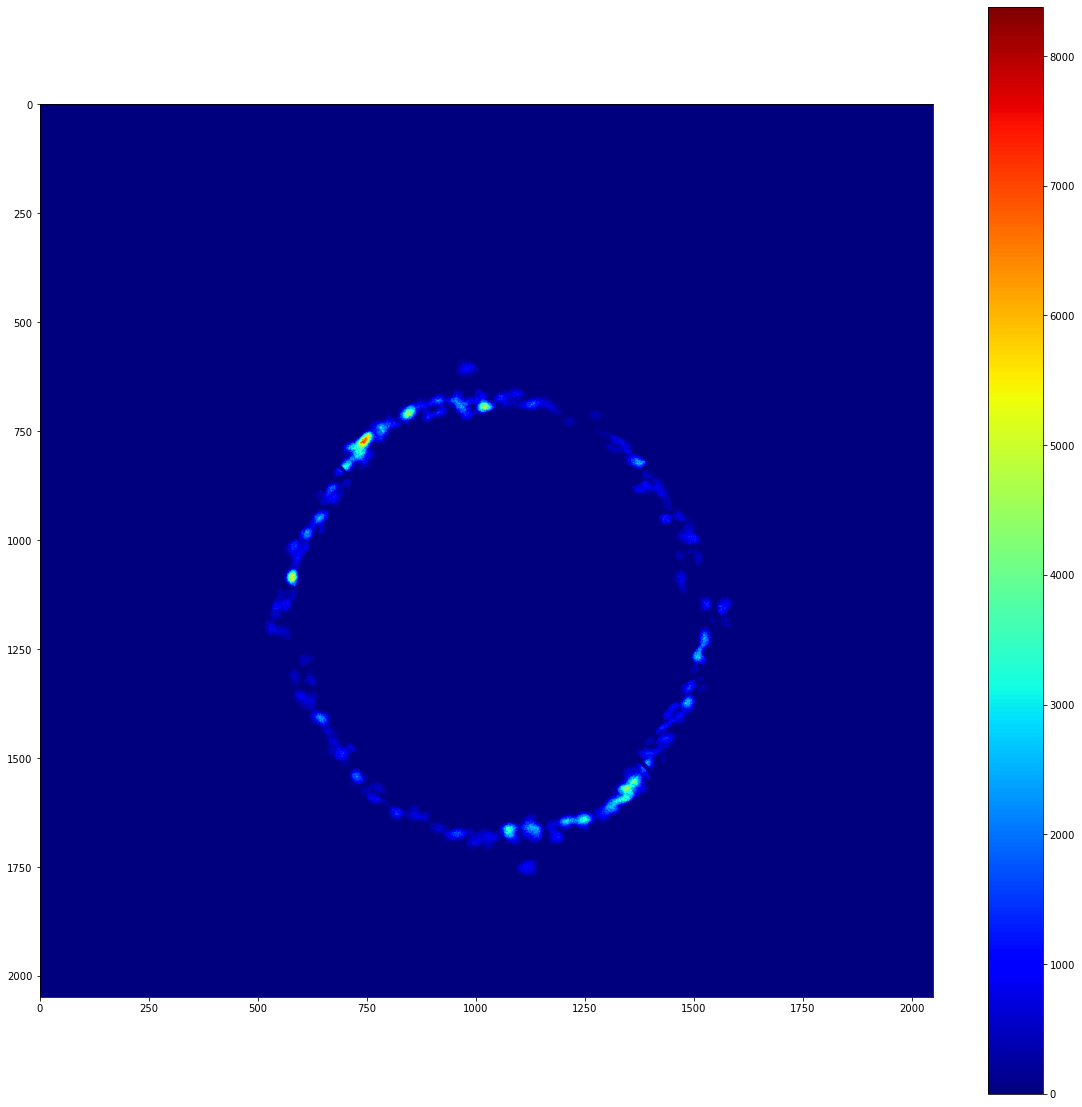

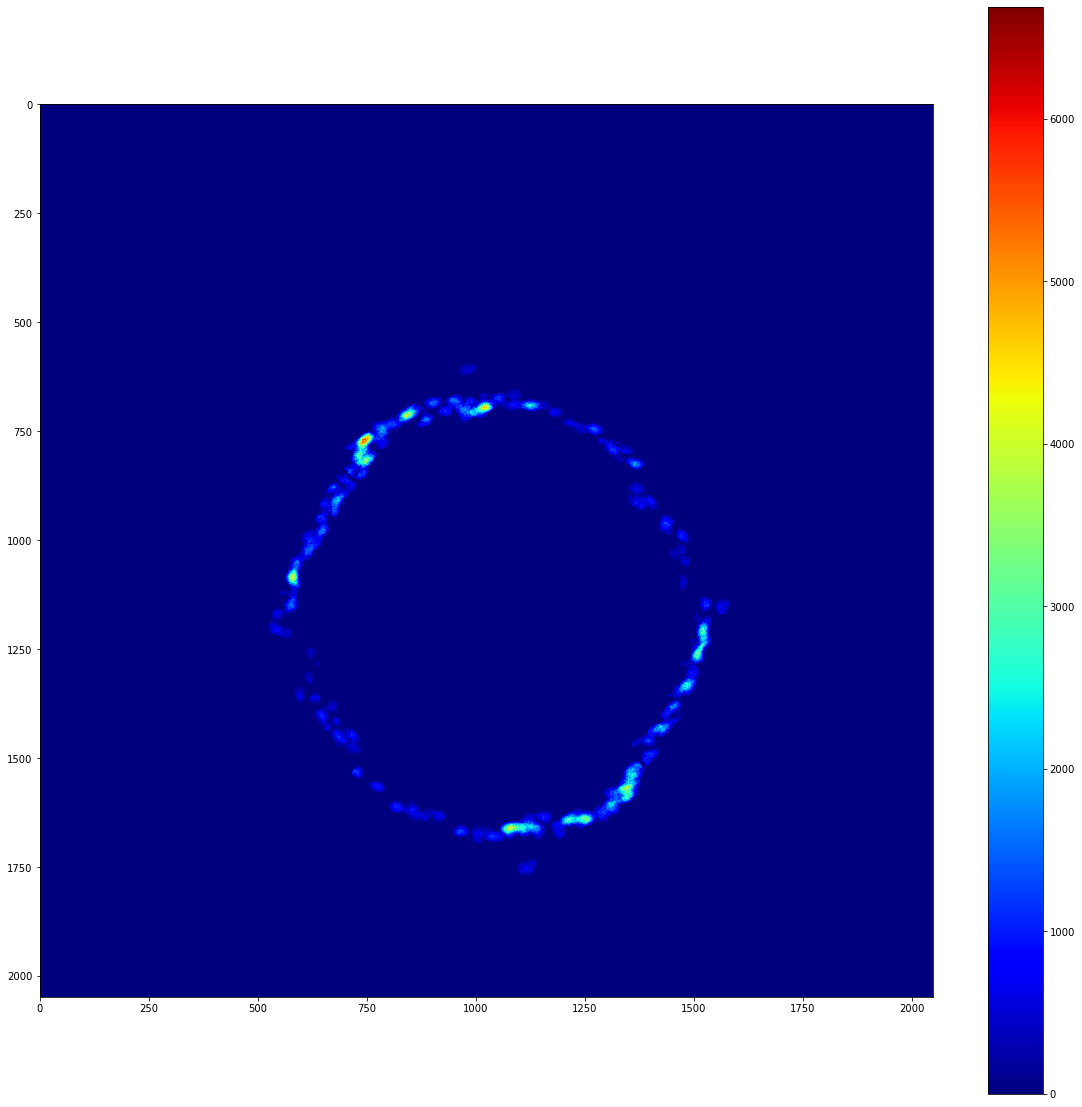

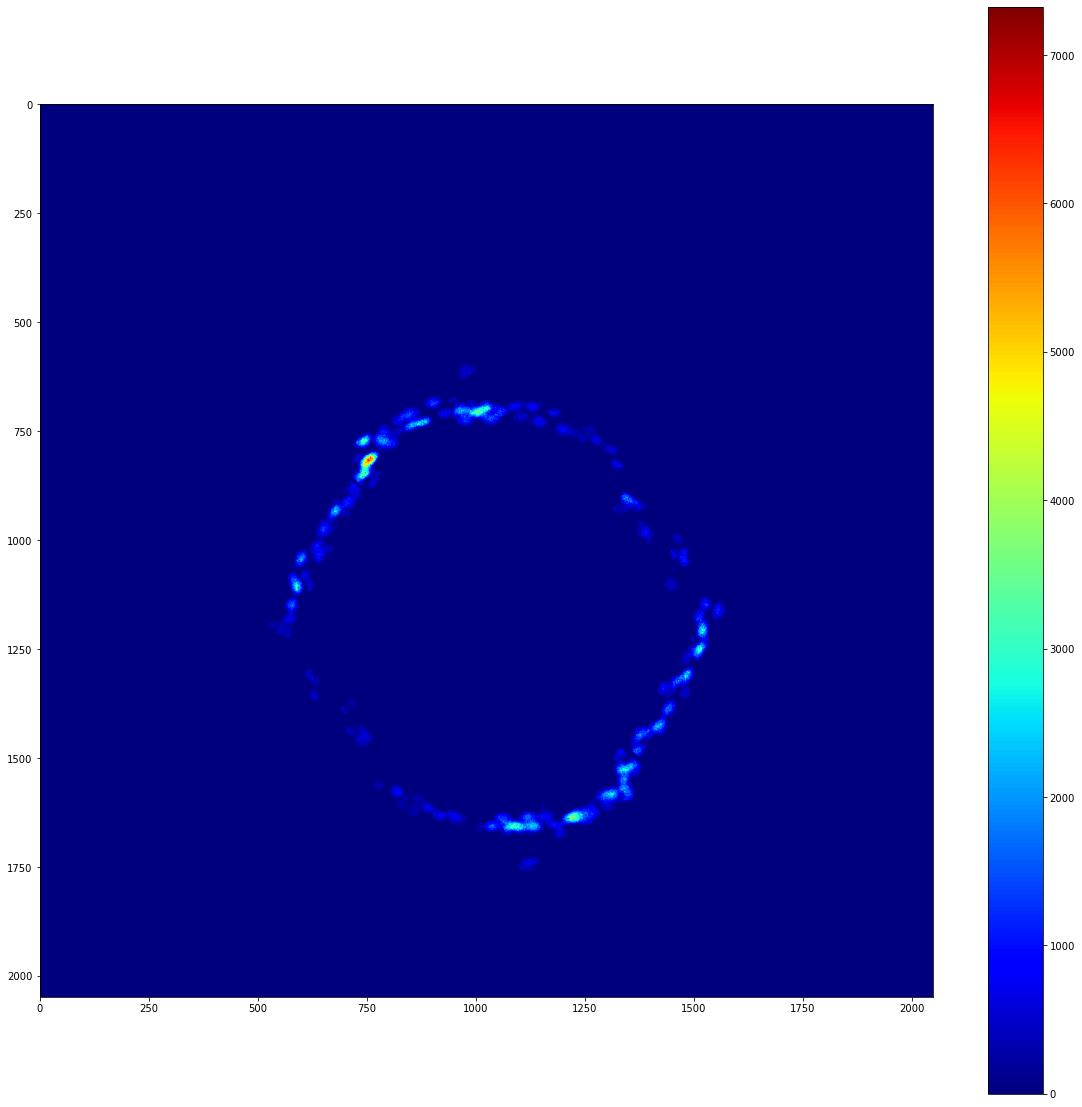

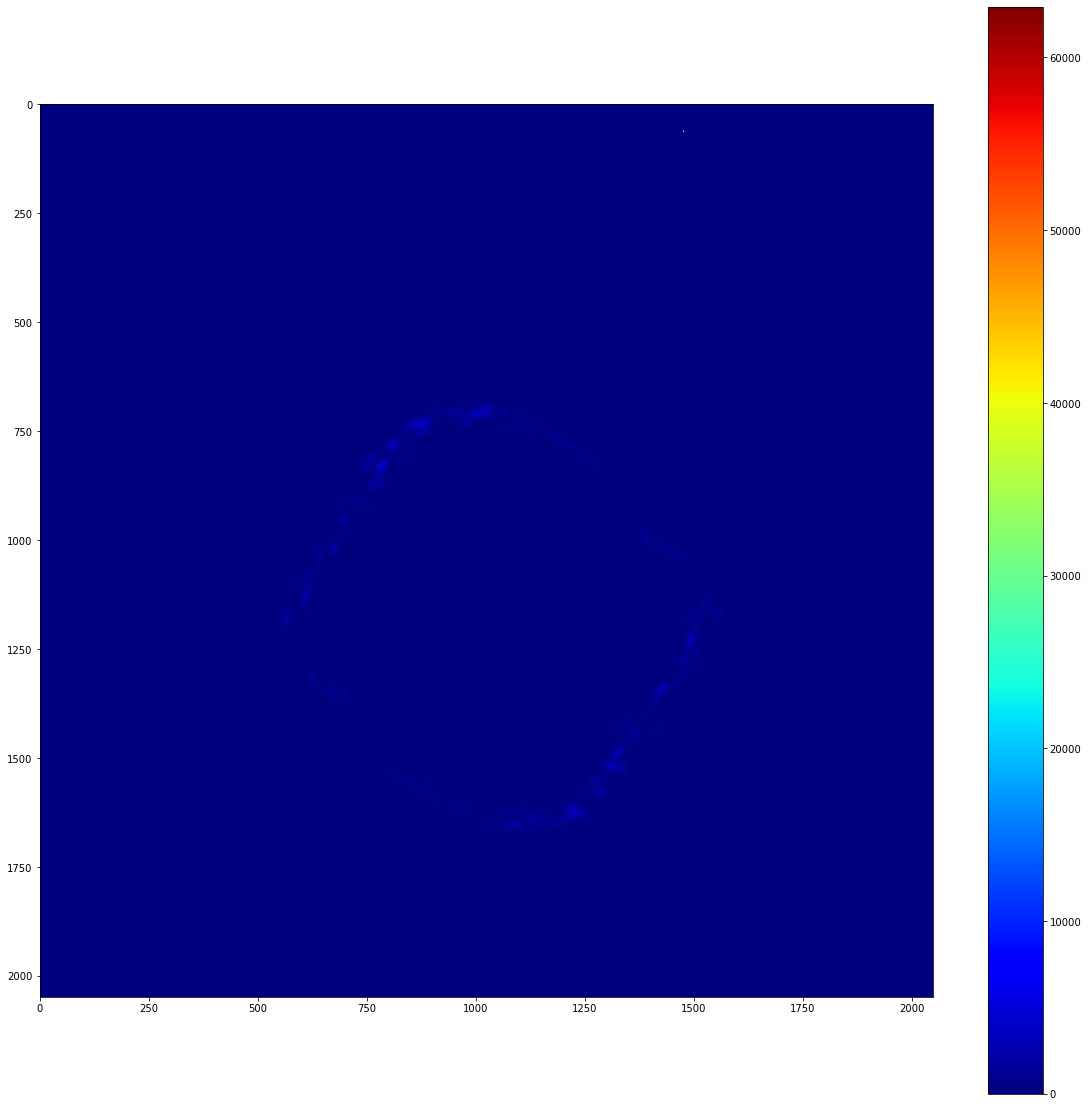

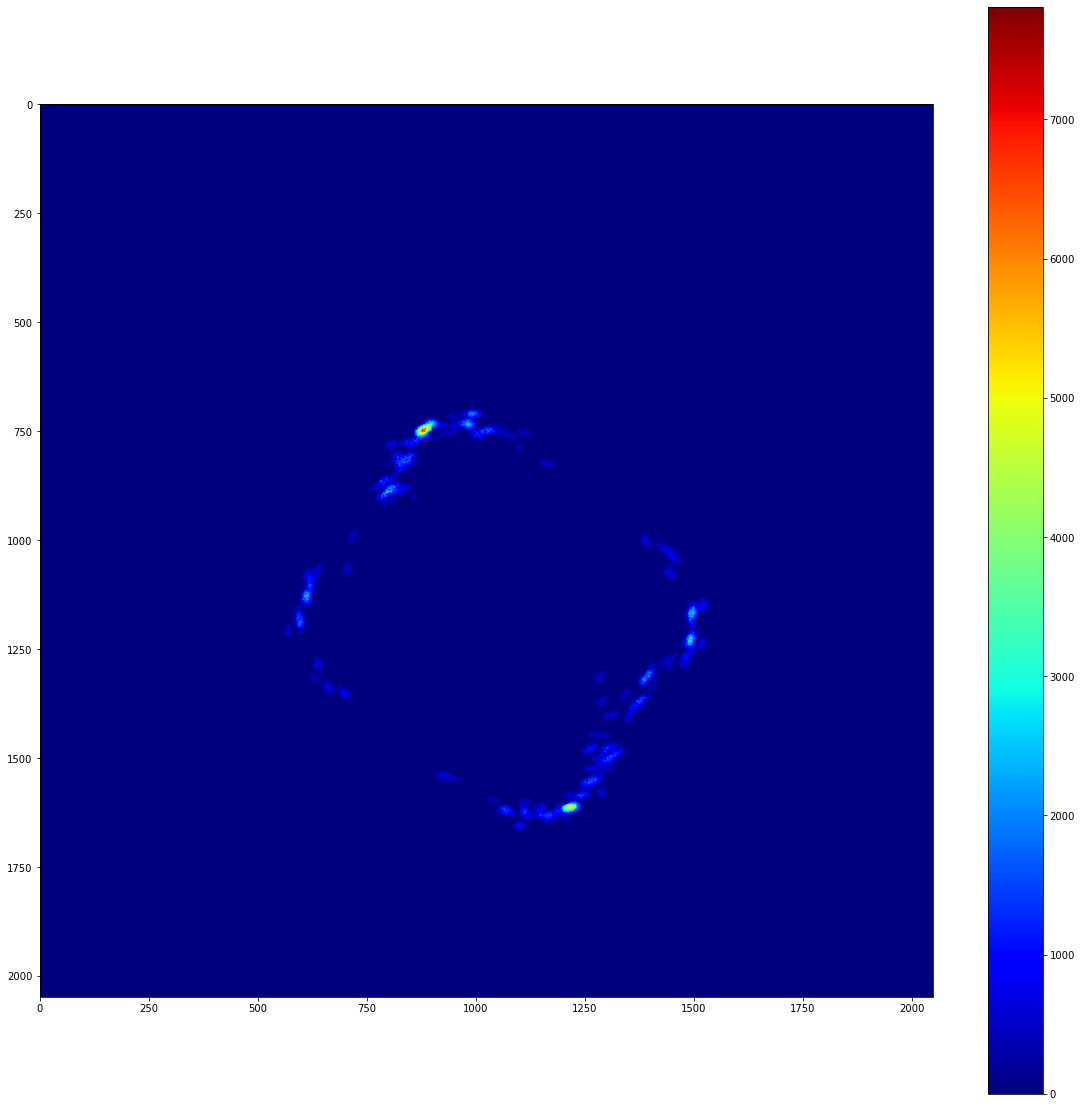

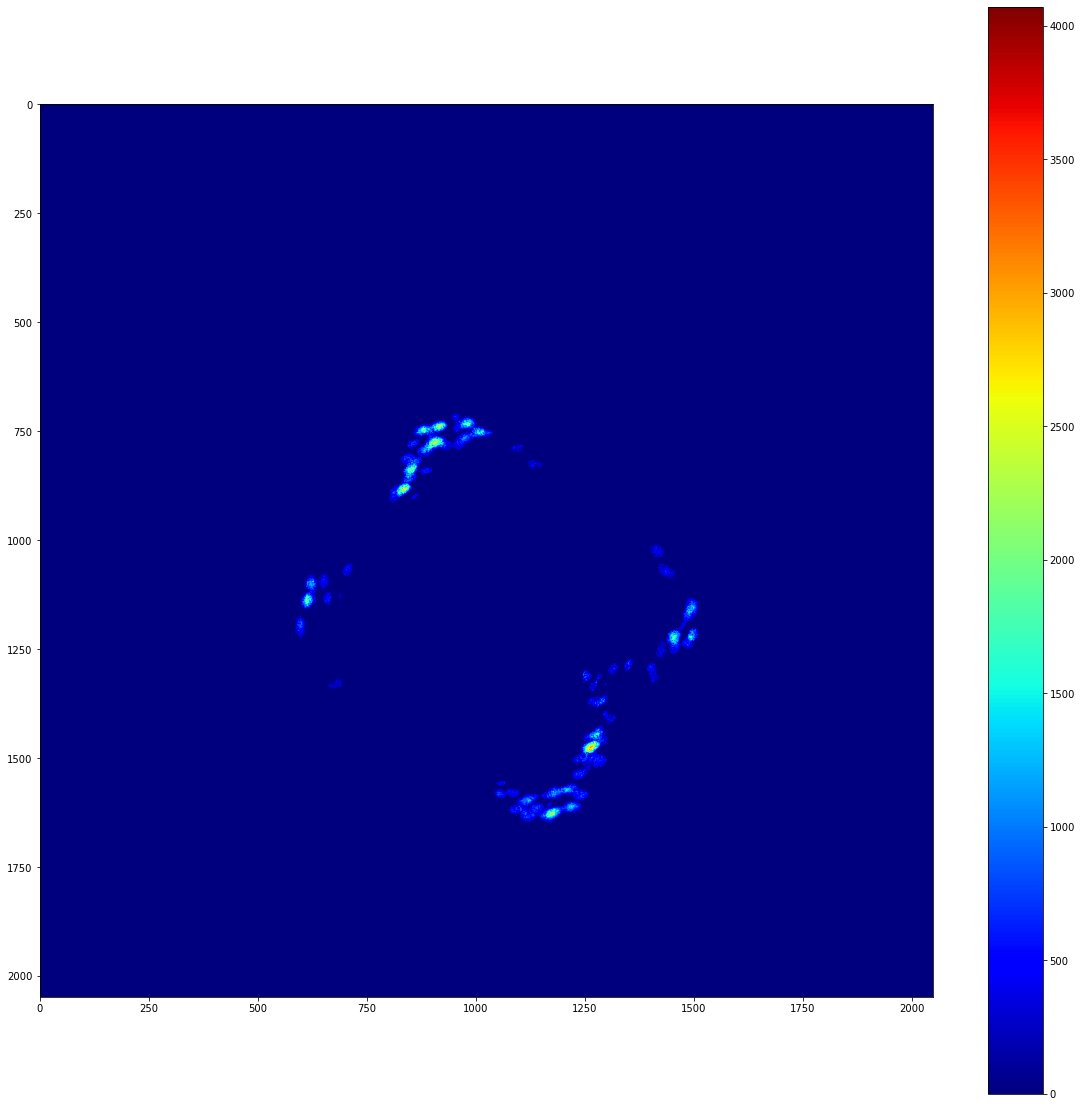

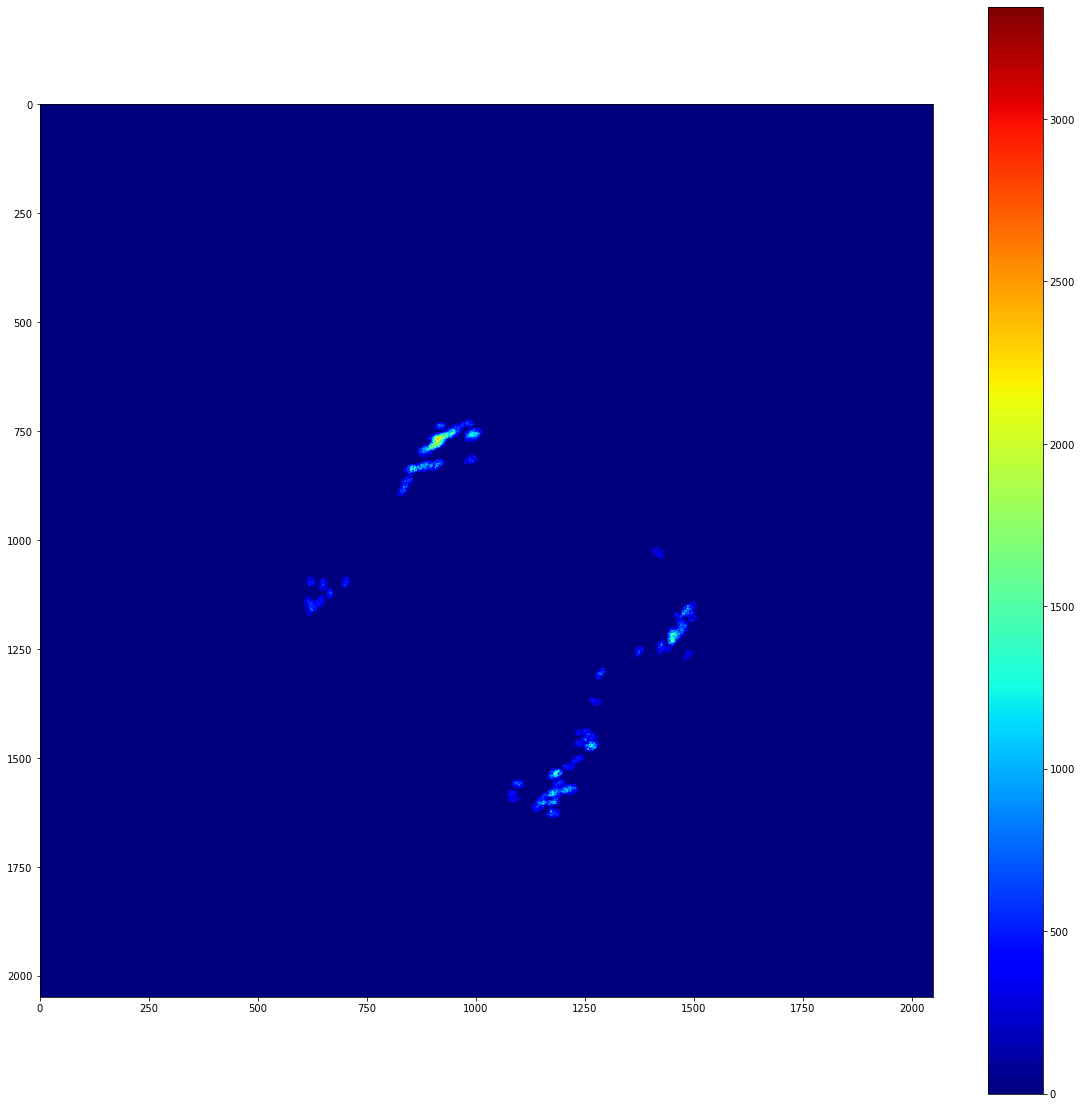

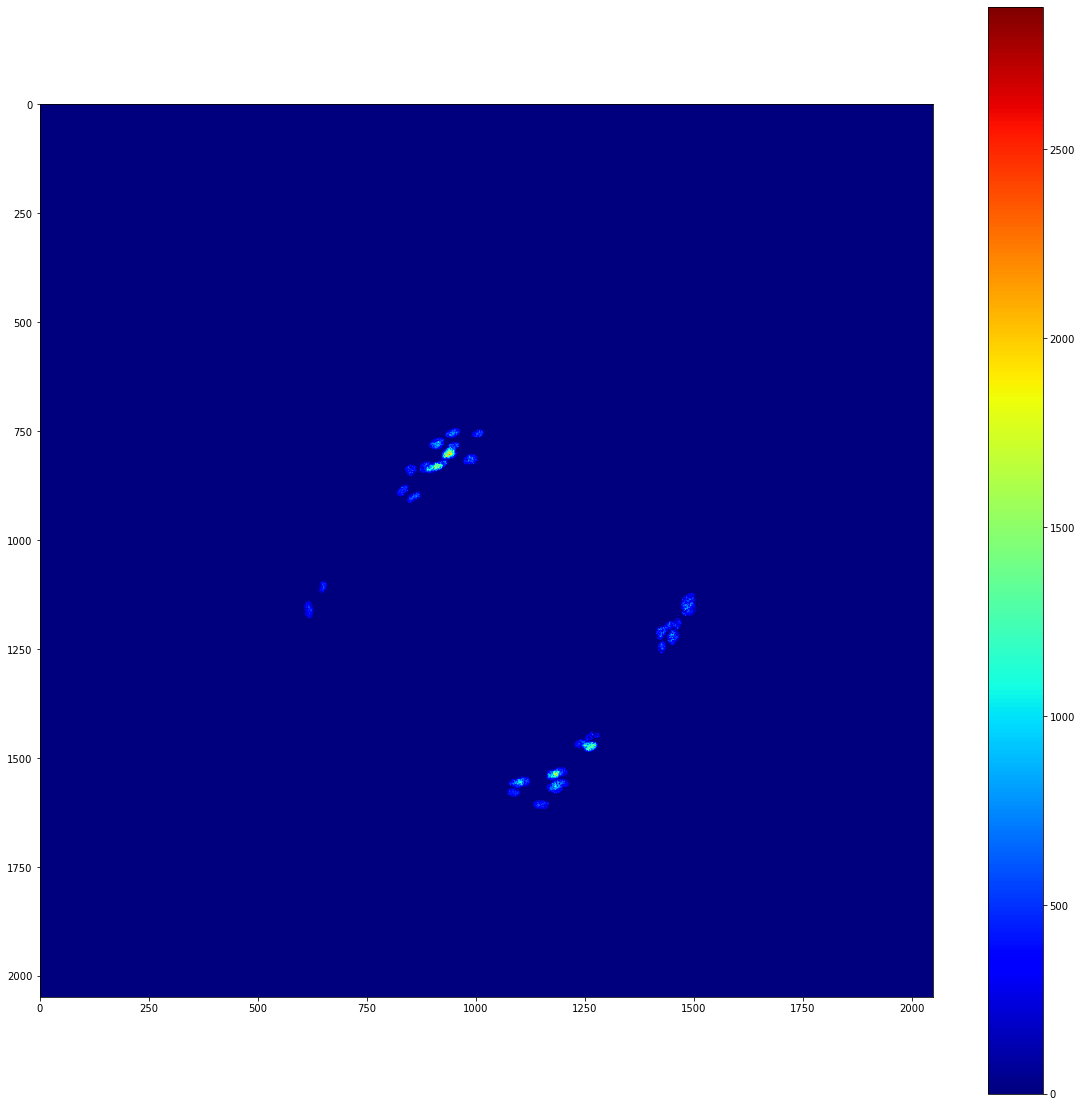

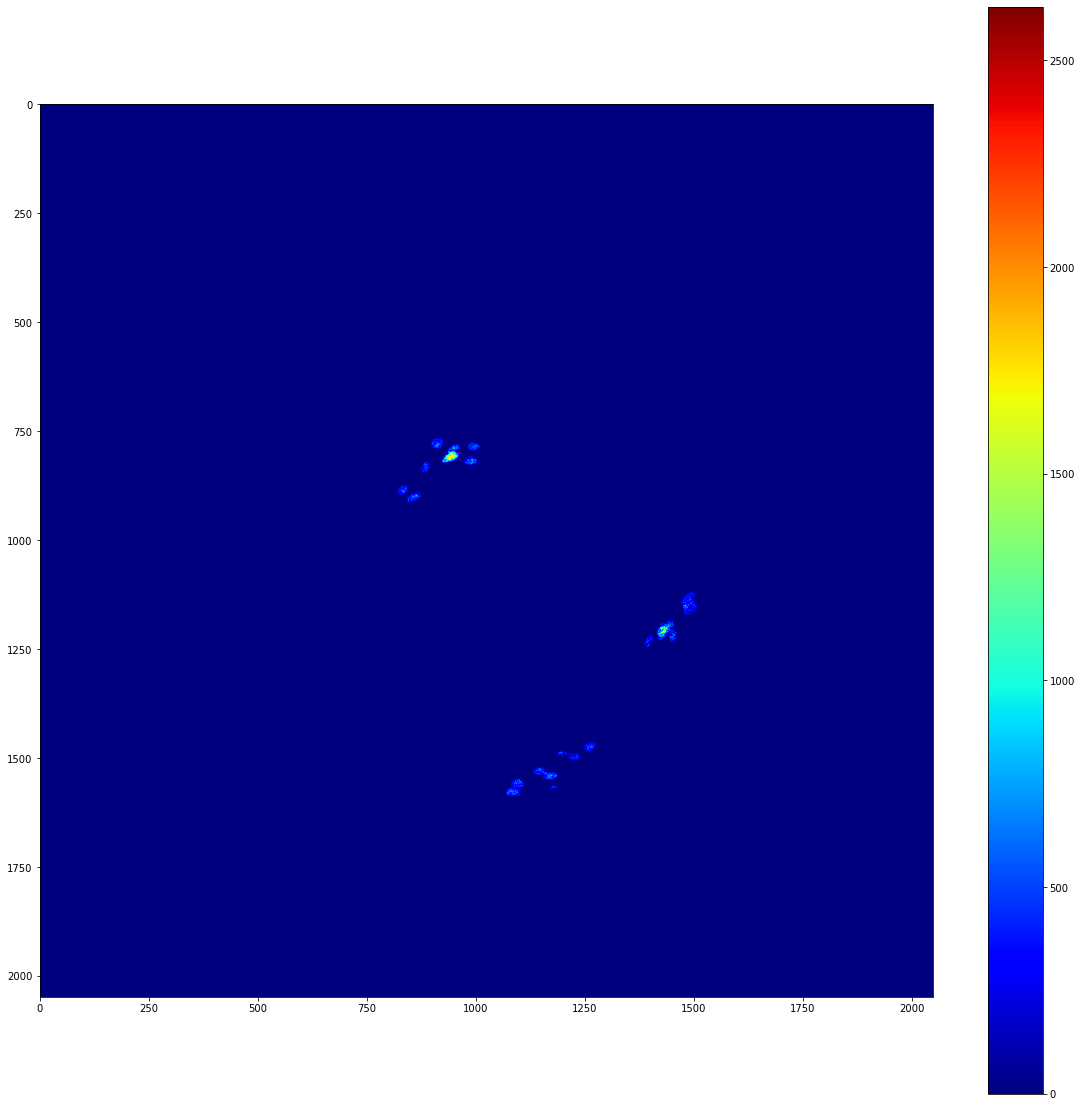

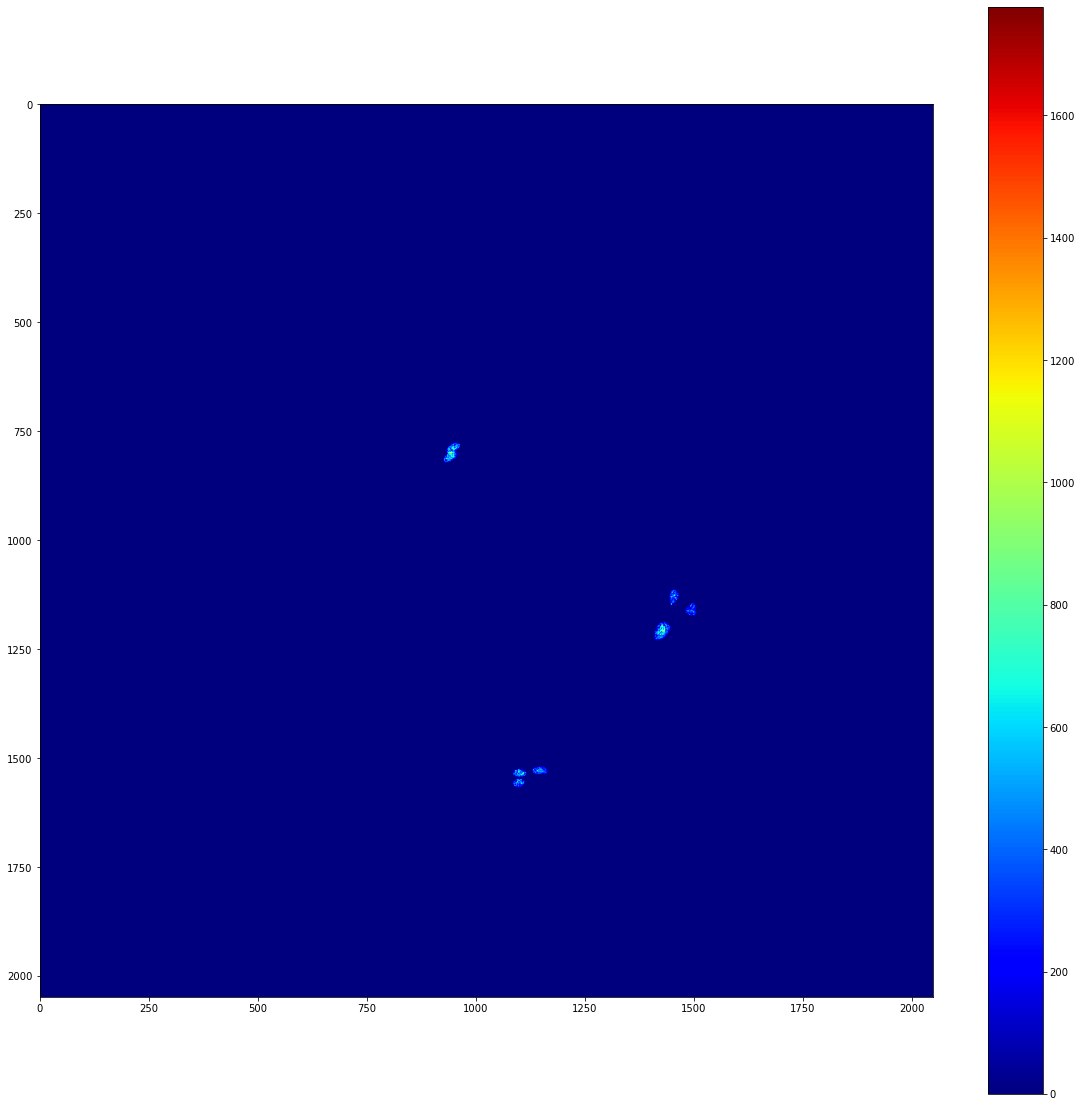

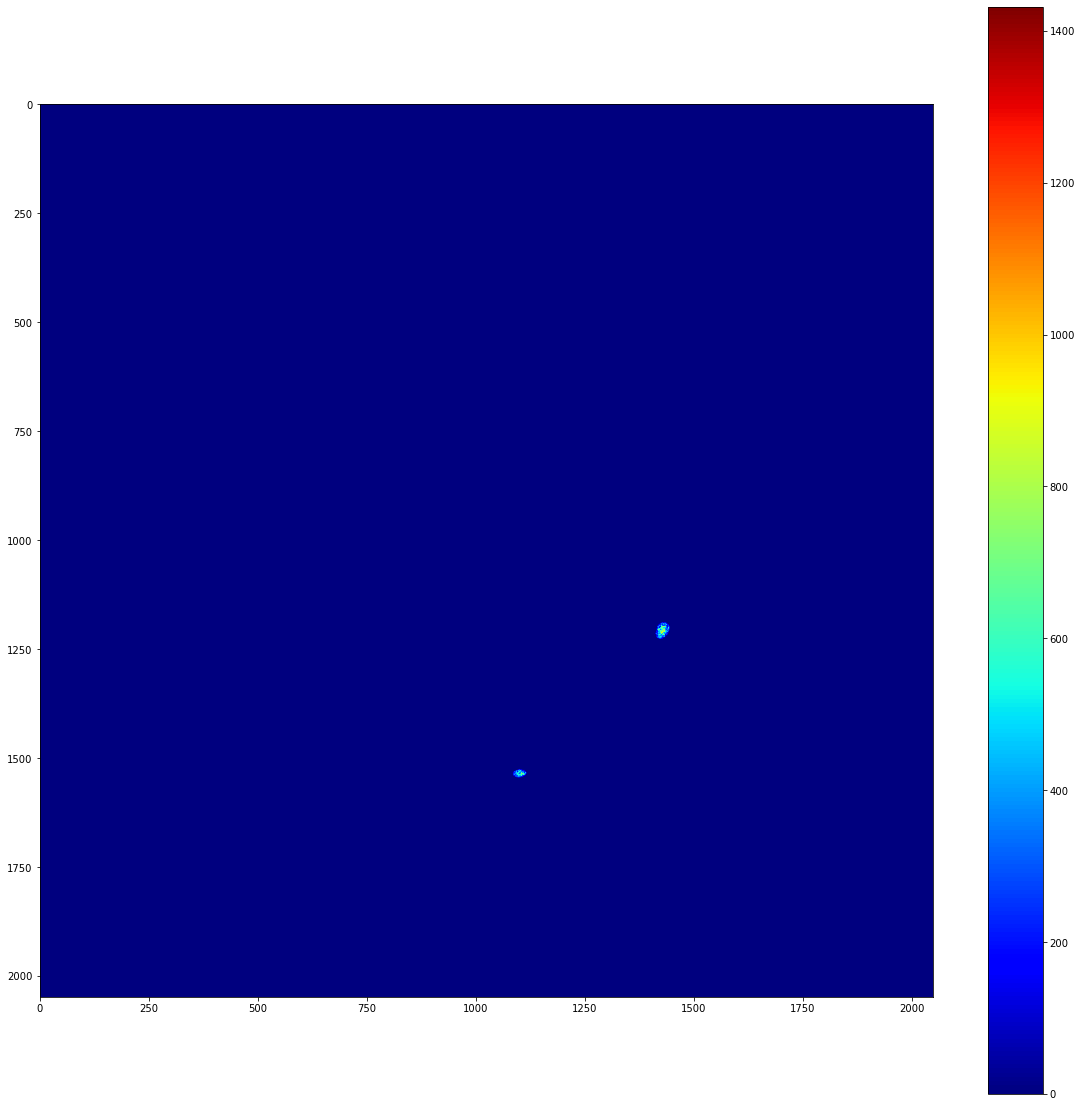

In [83]:
for field in range(30):
    utils.imshow(bkg_in_clusters_per_field[field])

In [1]:
"""
FROM HERE ON WORK IS DEPRECATED AS OF 11/03/2022
"""

NameError: name 'beam_centre_x' is not defined

In [ ]:

"""
The script.
"""
import importlib
import cluster
# Required because I've been developing the module while testing it. Unless
# you're actively developing the cluster module, you can comment out the
# following two lines.
import ccd_image as ccd
importlib.reload(cluster)
importlib.reload(ccd)

metadata = ccd.Metadata(beam_centre_x, beam_centre_y)
ALL_CLUSTERS = {1.5*x: [] for x in range(len(scan_dirs))}
images = []


for x, scan_dir in enumerate(scan_dirs):
    if x > 0:
        break
    for field in range(30):
        angle = x*1.5
        print(f"Processing scan {scan_dir} (angle={angle}) at {field} mT.")

        # Load the tiff; init the ccd image.
        tiff = get_tiff(scan_dir, field)
        ccdImage = ccd.CCDImage(tiff, get_rough_background(scan_dir), mask,
            metadata)

        # Run the generic processing on the image to produce significance map.
        ccdImage.subtract_bkg()
        ccdImage.wavelet_denoise()
        clusters = ccdImage.cluster_significant_pixels(20, 100)

        # Save the clusters.
        ALL_CLUSTERS[angle].append(clusters)
        images.append(ccdImage)



/var/folders/91/cjqffvc108ddp27nm67npc000000gn/T/ipykernel_46728/3238268890.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


AssertionError: 

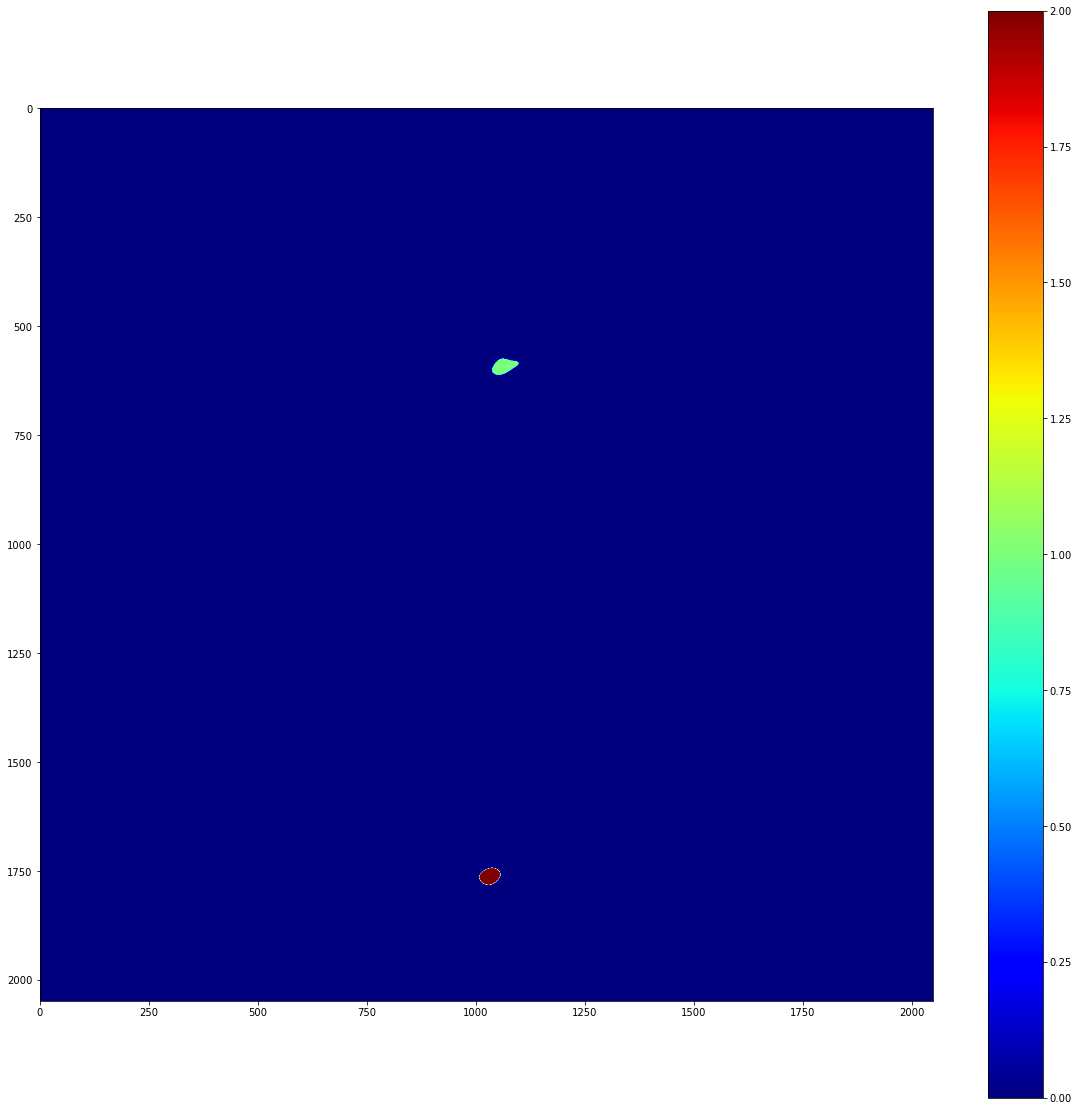

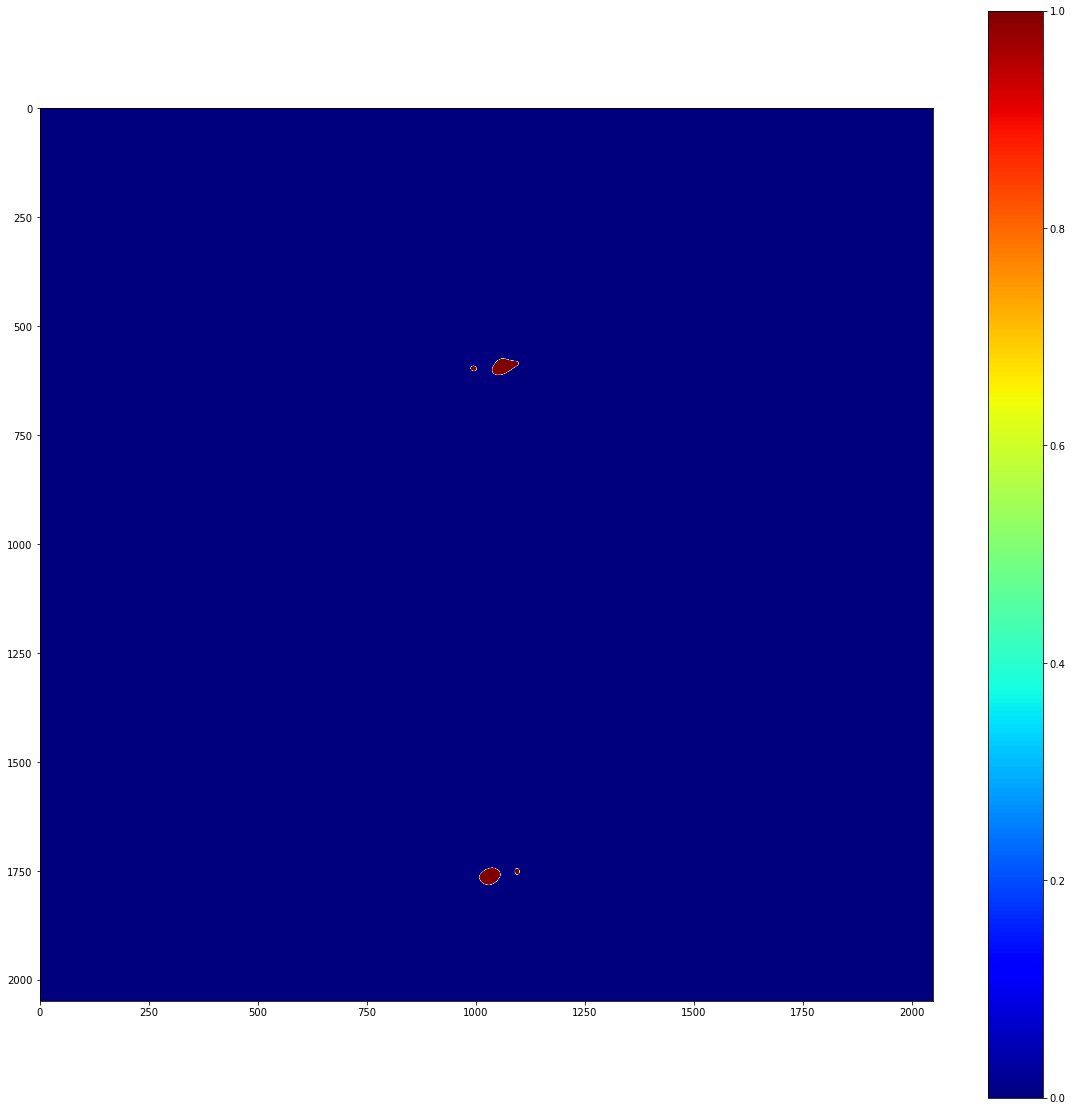

In [55]:
def imshow_cluster(clusters):
    clustered_img = np.zeros_like(get_tiff(scan_dirs[0], 0))
    for i, cluster in enumerate(clusters):
        pixels_x, pixels_y = cluster.pixel_indices
        clustered_img[pixels_y, pixels_x] = i+1

    imshow(clustered_img)

imshow_cluster(ALL_CLUSTERS[0][0])
imshow(images[0].significant_pixels)

assert 1 == 2

/var/folders/91/cjqffvc108ddp27nm67npc000000gn/T/ipykernel_33917/3238268890.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


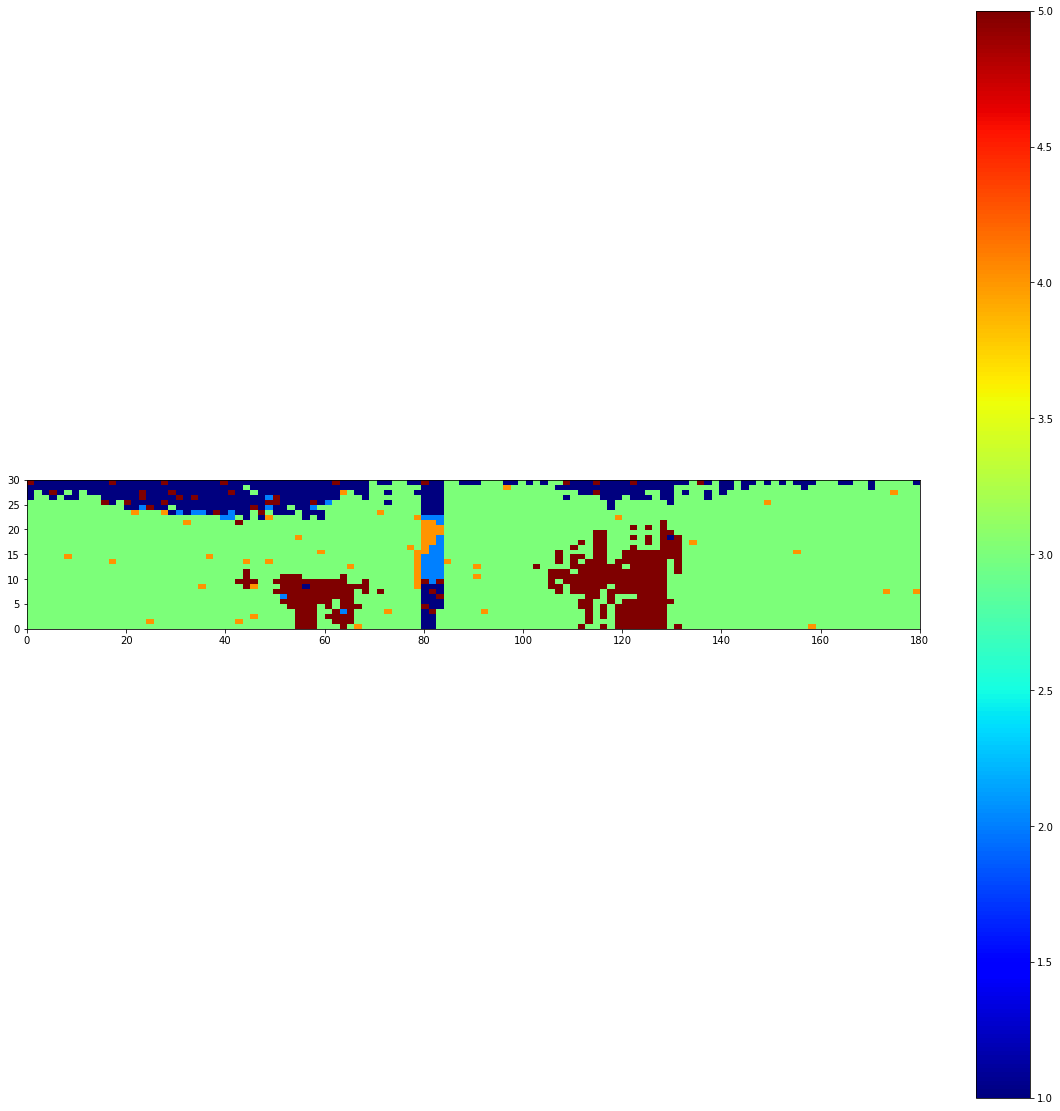

In [ ]:
"""
Now lets analyse the clusters that we got. First up is a phase map of solitons,
cones and FP.
"""

from typing import List
from enum import IntEnum, auto
import cluster
# Required because I've been developing the module while testing it. Unless
# you're actively developing the cluster module, you can comment out the
# following two lines.
importlib.reload(cluster)


class State(IntEnum):
    FIELD_POLARIZED = auto()
    CONICAL = auto()
    SOLITON = auto()
    SOLITON_AND_CONICAL = auto()
    UNKNOWN = auto()

def calculate_state(clusters: List[cluster.Cluster], field_angle: float):
    """
    Works out what the State is represented by a list of clusters.
    """
    if len(clusters) == 0:
        return [State.FIELD_POLARIZED]

    classifications = []
    for cluster in clusters:
        # Grab the azimuthal angle of the centre of mass of the cluster.
        cluster_x = cluster.mean[0]
        cluster_y = cluster.mean[1]
        dx = beam_centre_x - cluster_x
        dy = cluster_y - beam_centre_y
        cluster_angle = np.arctan2(dx, dy)*180/np.pi

        # Calculate acceptance bounds for different magnetic states.
        soliton_angle_1 = field_angle
        soliton_angle_2 = field_angle - 180
        cone_angle_1 = field_angle + 90
        cone_angle_2 = field_angle - 90

        atol = 10

        # Work out if we're a soliton, a cone, or something unknown.
        if np.isclose(soliton_angle_1, cluster_angle, atol=atol) or \
            np.isclose(soliton_angle_2, cluster_angle, atol=atol):
            classifications.append(State.SOLITON)
        elif np.isclose(cone_angle_1, cluster_angle, atol=atol) or \
                np.isclose(cone_angle_2, cluster_angle, atol=atol):
            classifications.append(State.CONICAL)
        else:
            classifications.append(State.UNKNOWN)

    return classifications
    


# Make a pseudo-dataframe to store the states.
STATES = {
    angle: [-1 for _ in range(30)] for angle in np.arange(0, 180, 1.5)
}

# Lets also make a quick and dirty plottable state map.
state_map = np.zeros((120, 30)) - 1

for angle in np.arange(0, 180, 1.5):
    for field in range(30):
        angle_idx = int(angle/1.5)
        clusters = ALL_CLUSTERS[angle][field]
        STATES[angle][field] = calculate_state(clusters, angle)

        # This is... pretty disgusting on the eyes.
        if State.FIELD_POLARIZED in STATES[angle][field]:
            state_map[angle_idx, field] = State.FIELD_POLARIZED
        elif State.CONICAL in STATES[angle][field]:
            if State.SOLITON in STATES[angle][field]:
                state_map[angle_idx, field] = State.SOLITON_AND_CONICAL
            else:
                state_map[angle_idx, field] = State.CONICAL
        elif State.SOLITON in STATES[angle][field]:
            state_map[angle_idx, field] = State.SOLITON
        else:
            state_map[angle_idx, field] = State.UNKNOWN

imshow(np.flip(state_map.transpose(), axis=0), extent=[0,180,0,30])
# BLUE = FIELD POLARIZED
# ORANGE = SOLITON AND CONICAL
# BROWN = UNKNOWN

UNKNOWN AT ANGLE OF 0.0 + 29 mT


/var/folders/91/cjqffvc108ddp27nm67npc000000gn/T/ipykernel_33917/3238268890.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


UNKNOWN AT ANGLE OF 4.5 + 27 mT
UNKNOWN AT ANGLE OF 15.0 + 25 mT
UNKNOWN AT ANGLE OF 16.5 + 29 mT
UNKNOWN AT ANGLE OF 19.5 + 25 mT


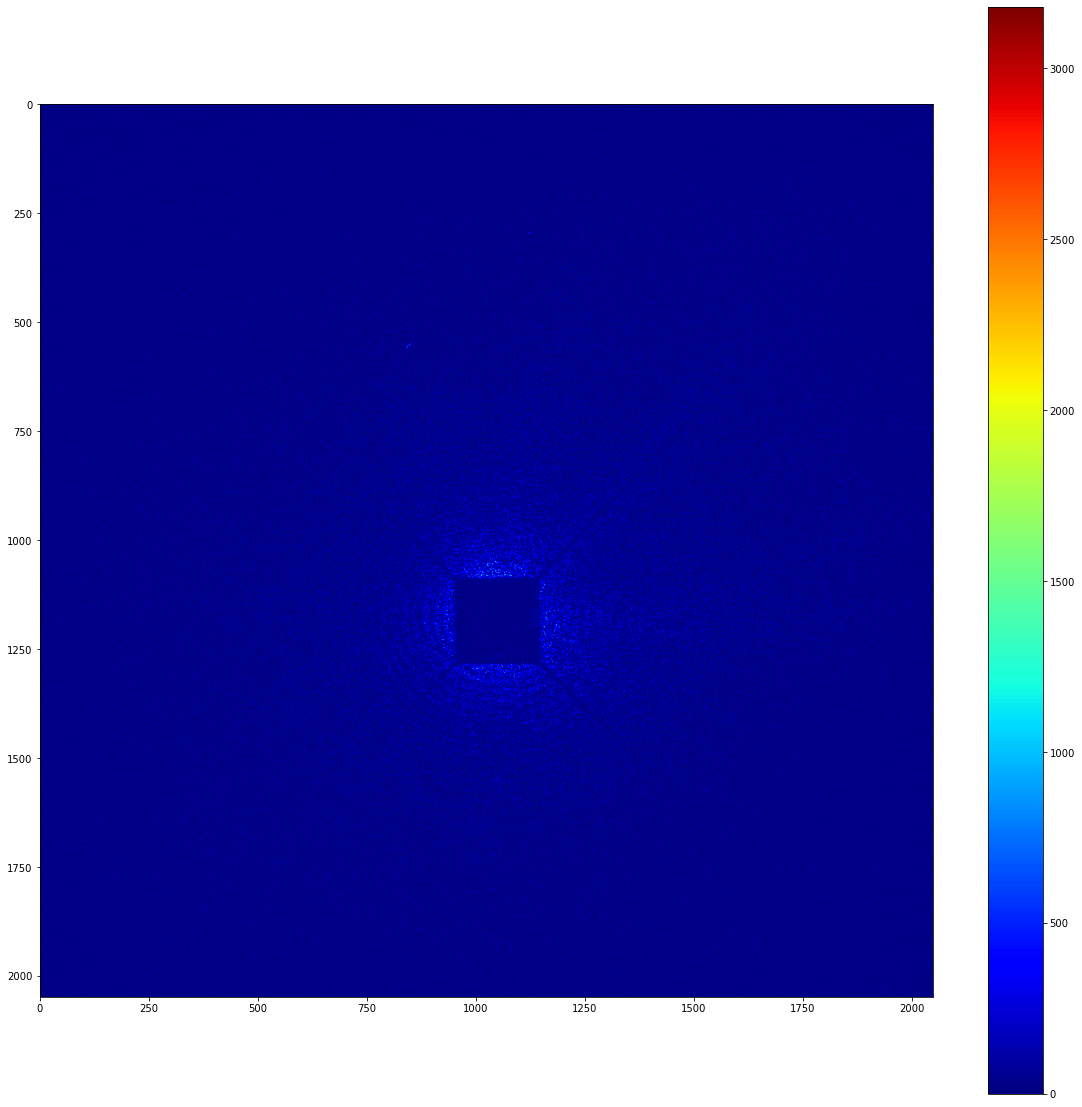

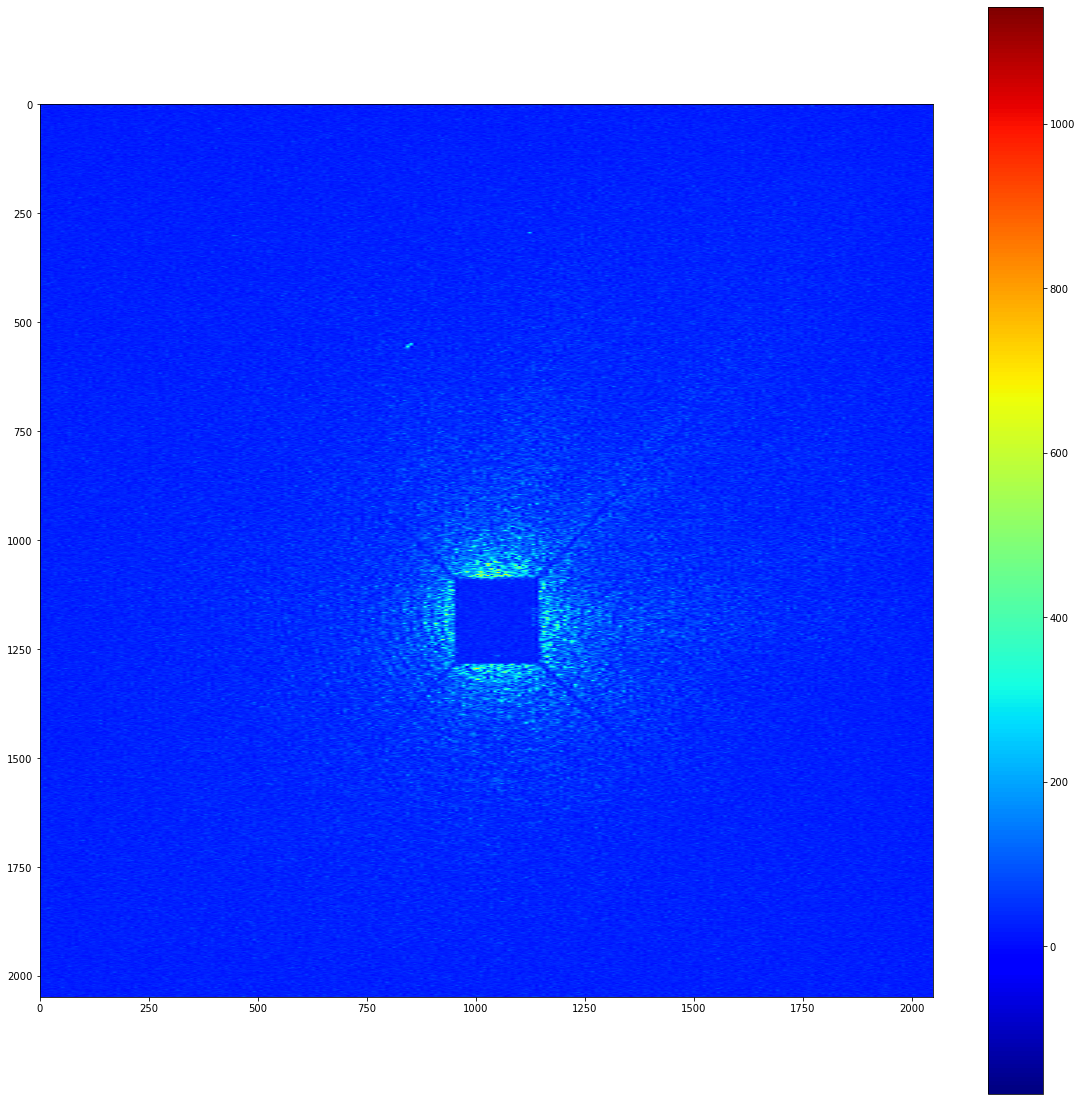

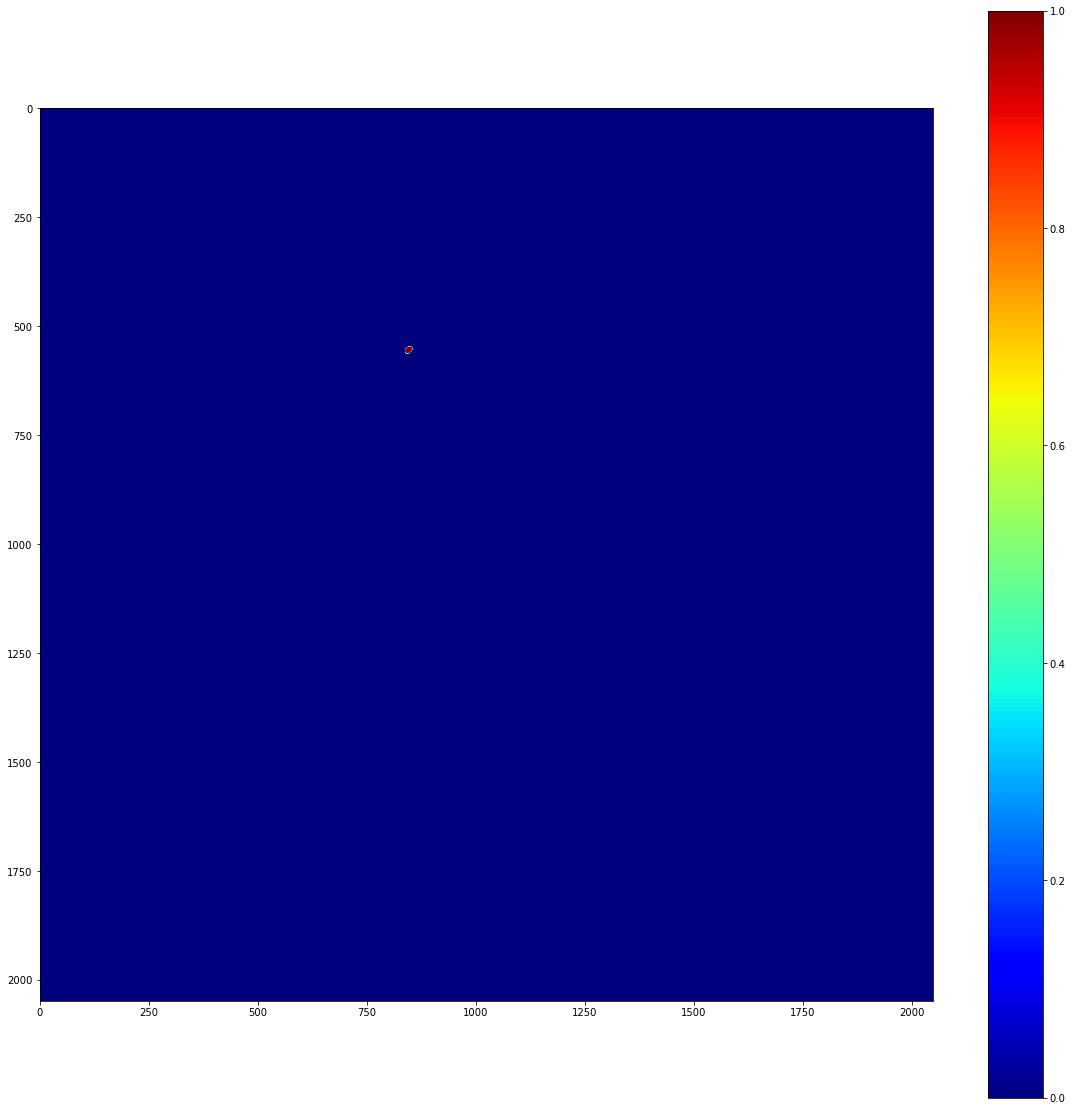

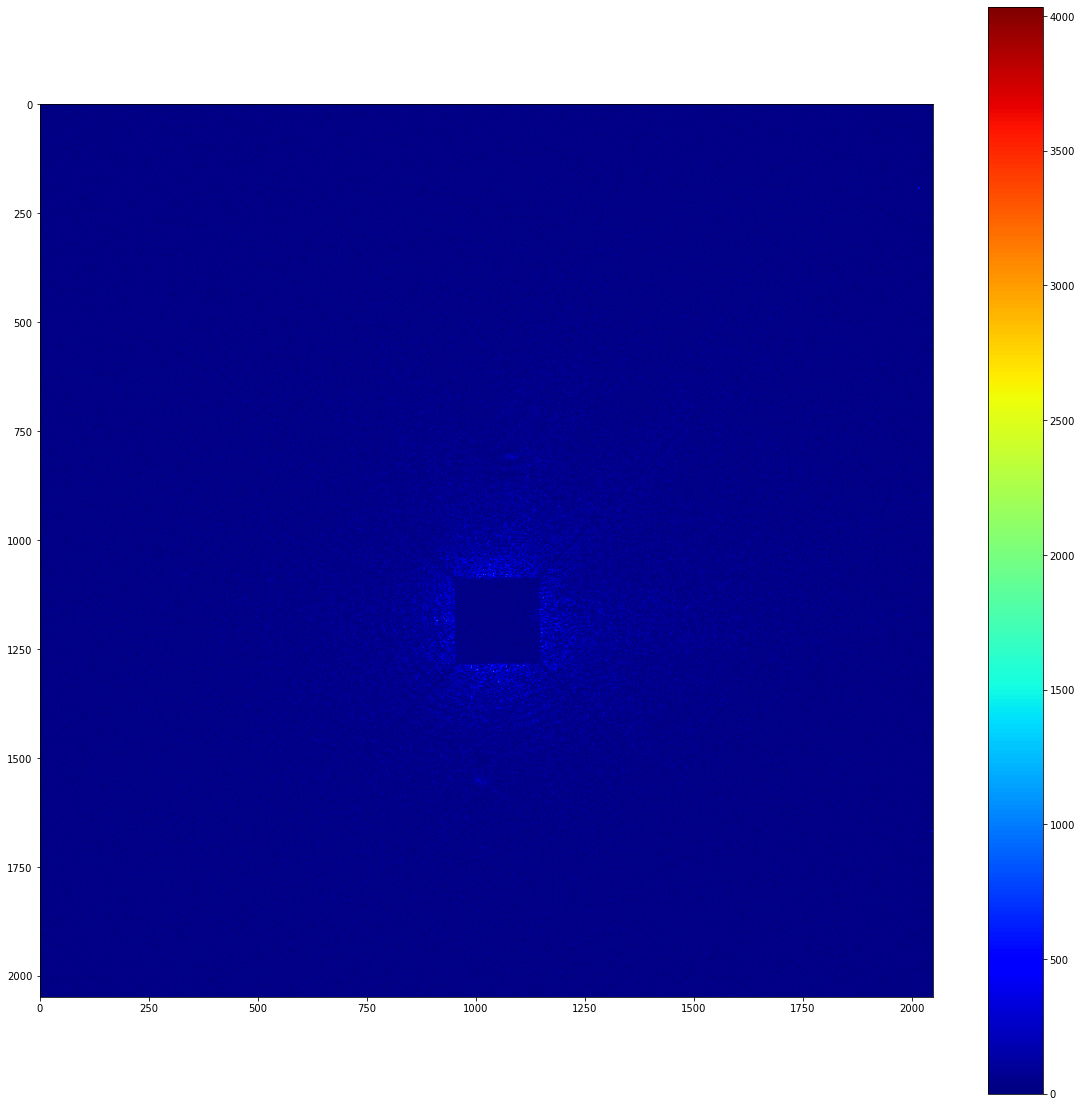

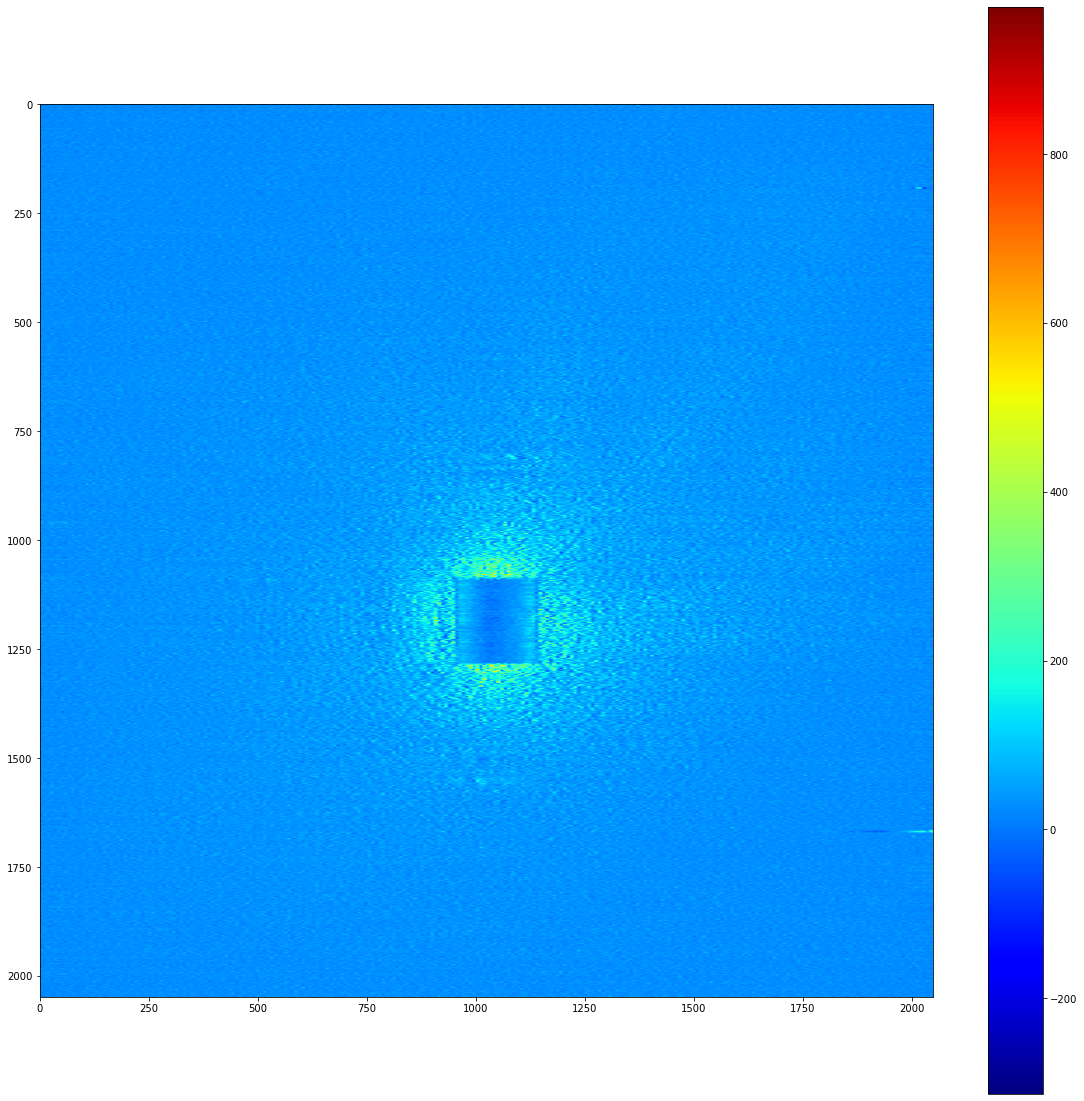

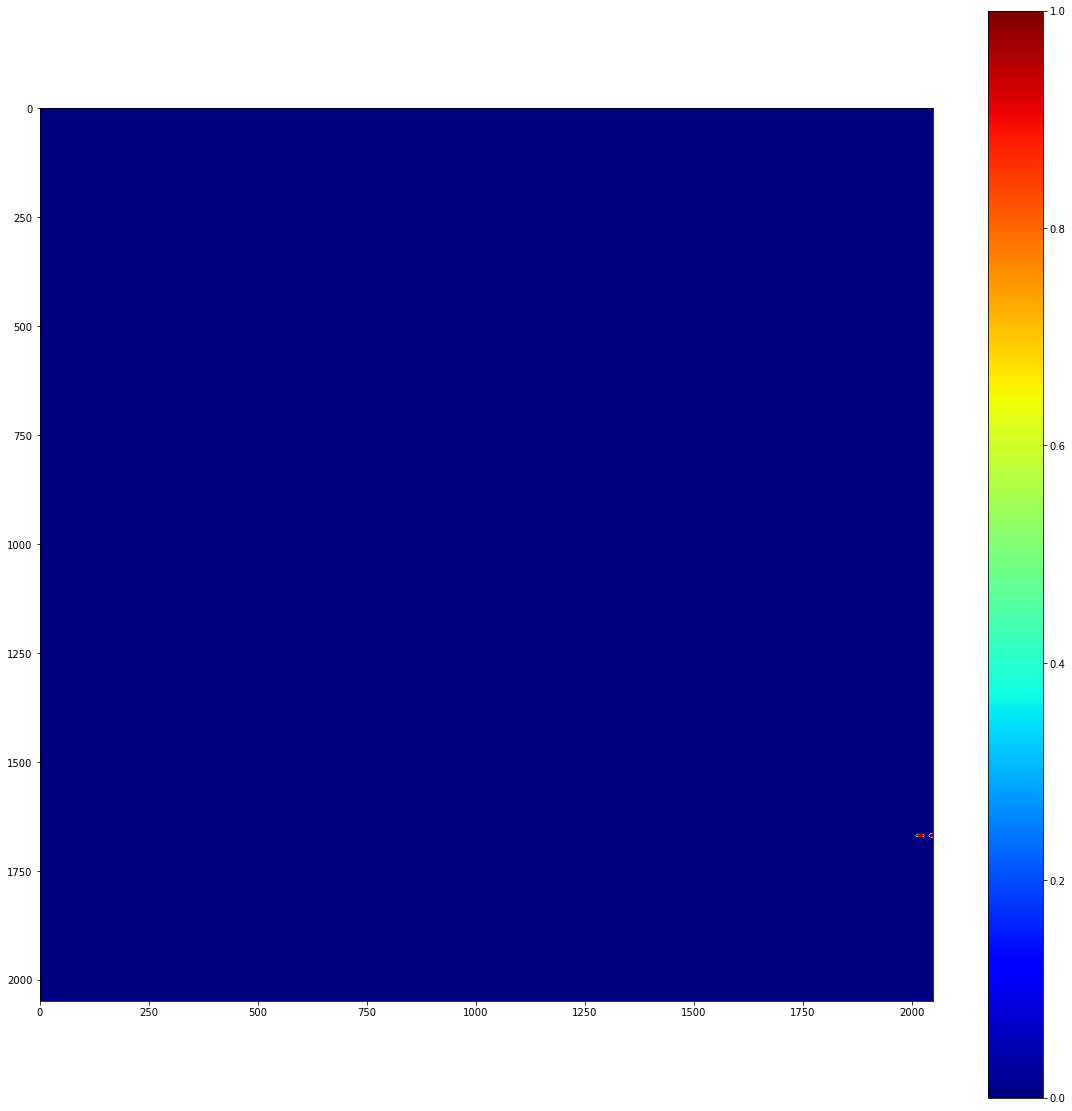

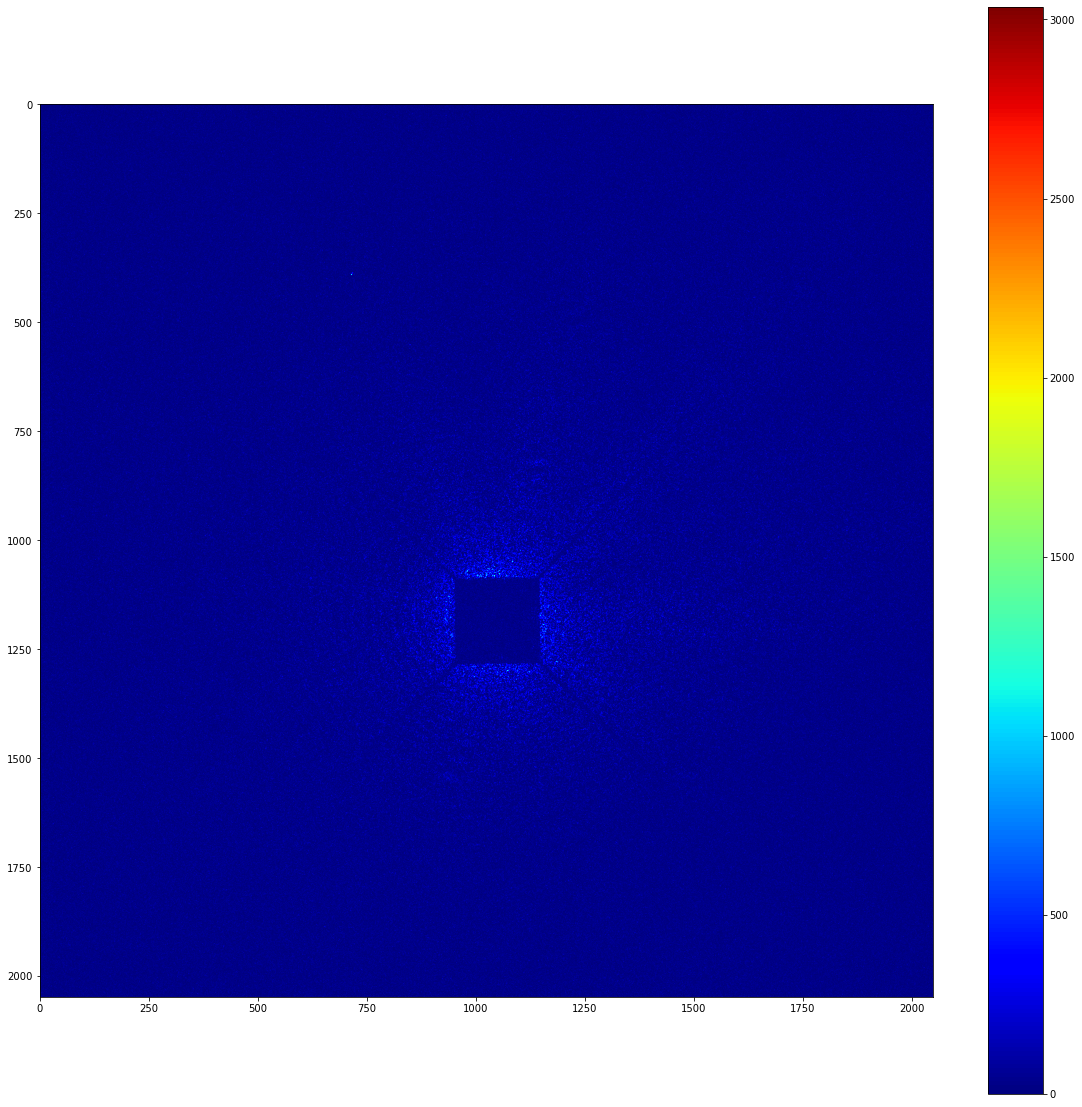

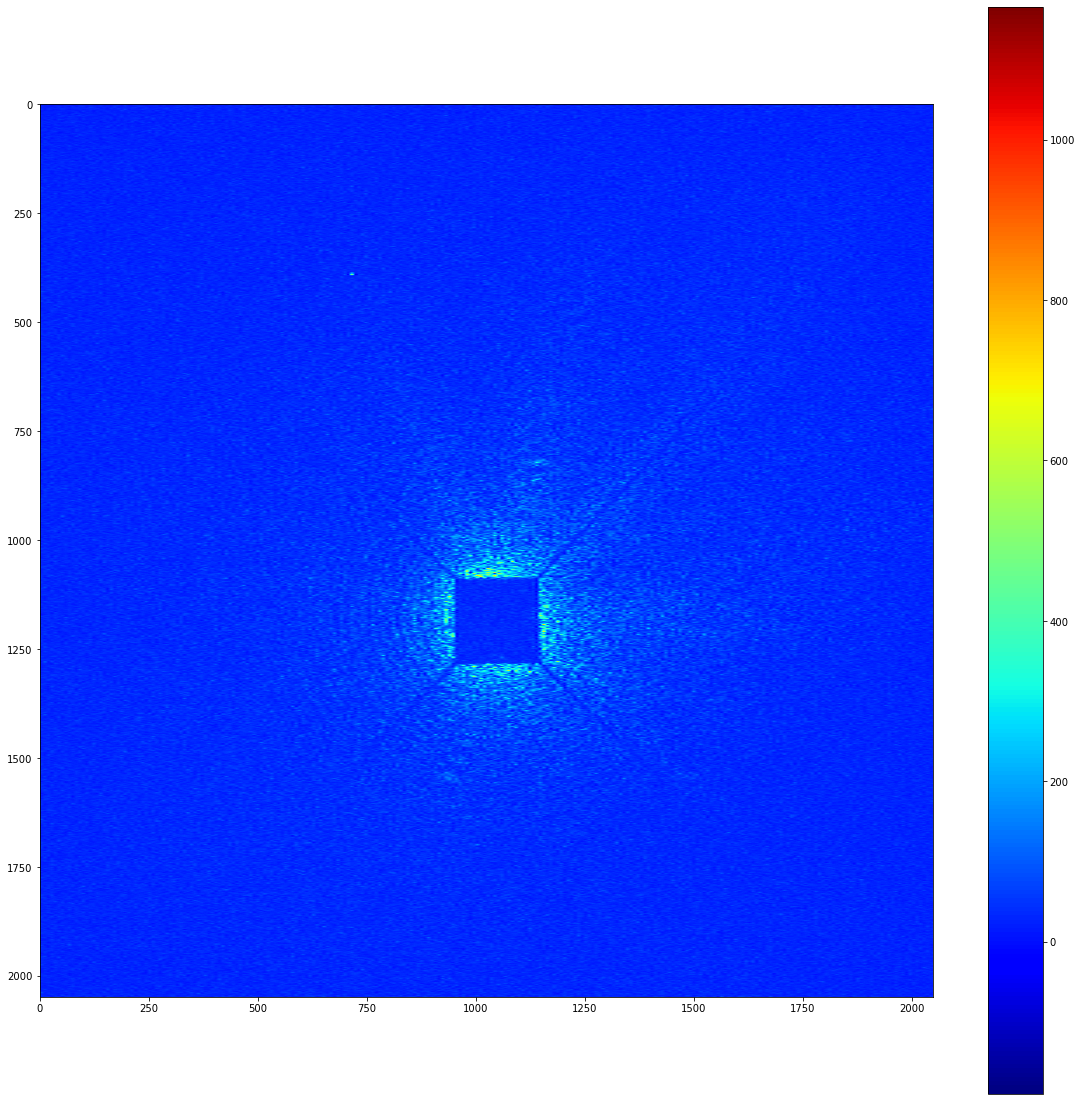

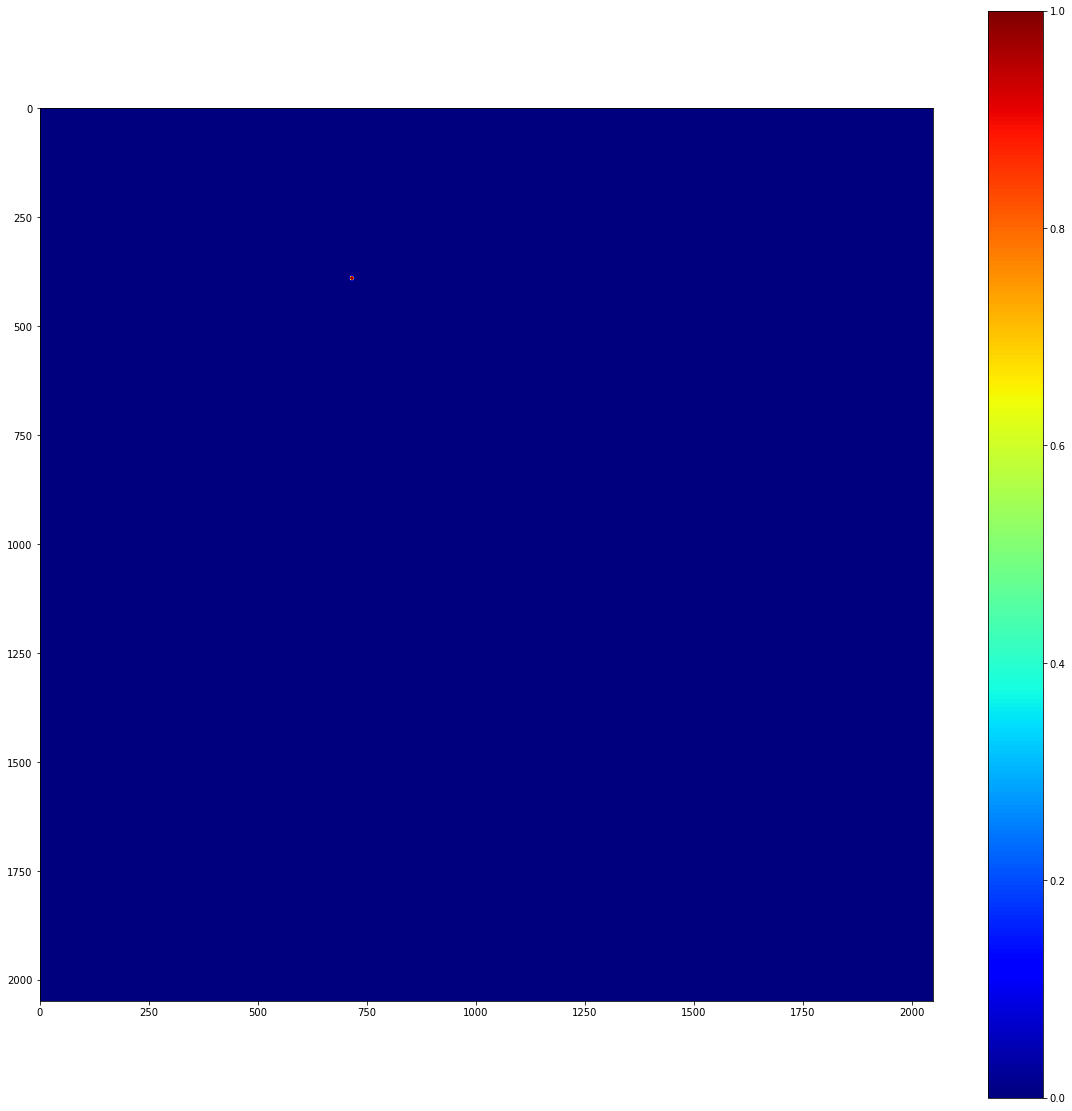

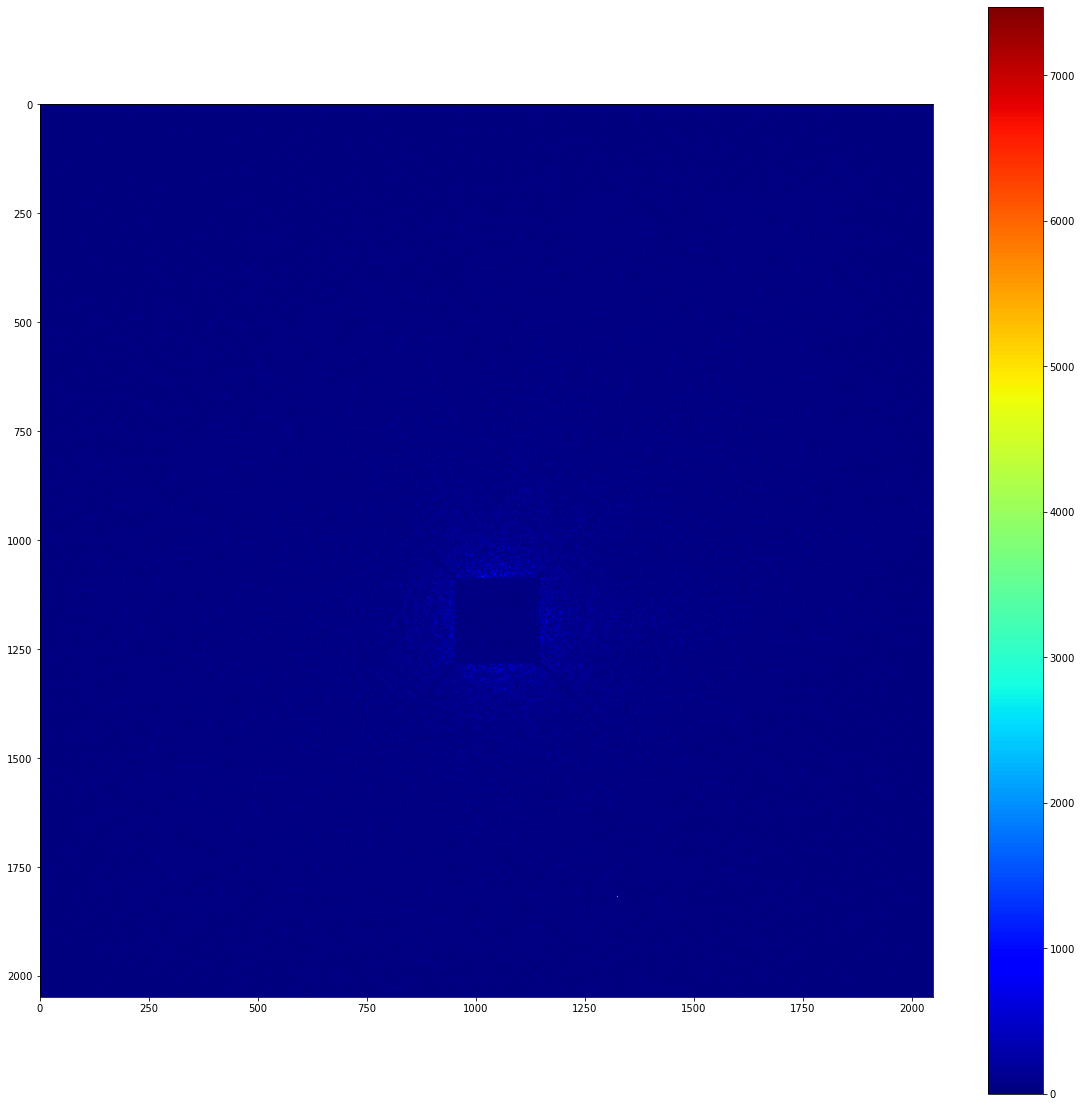

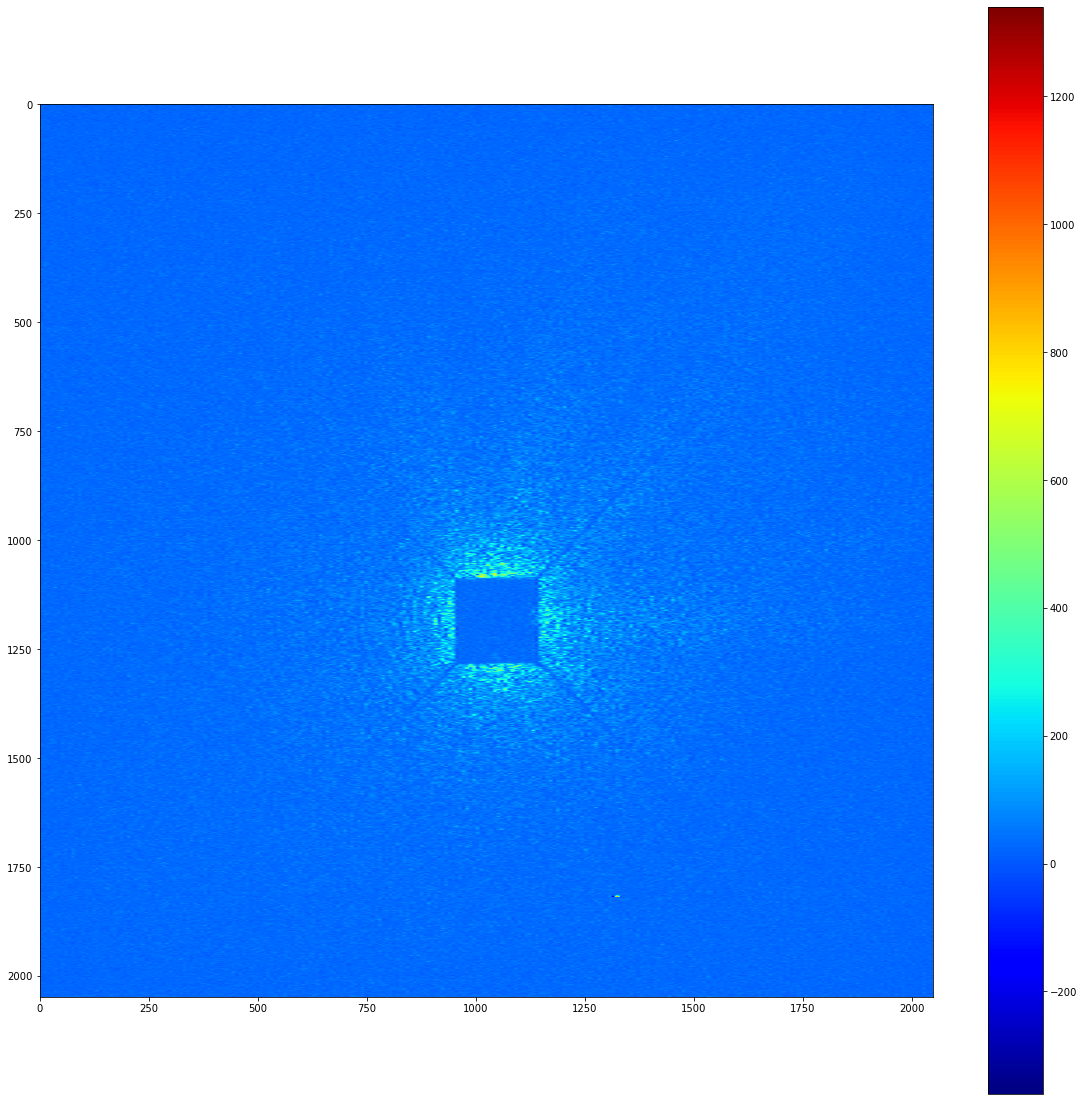

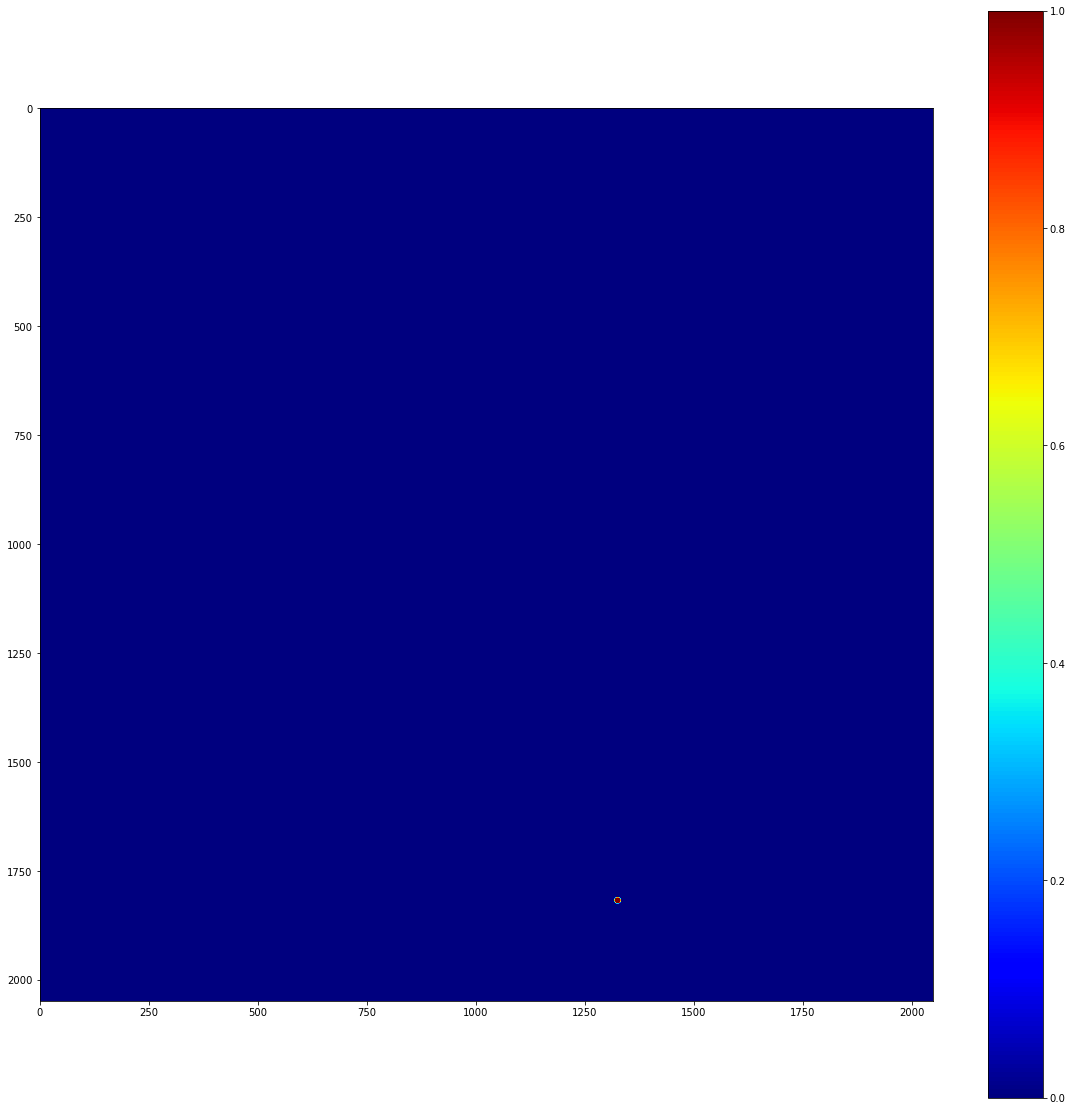

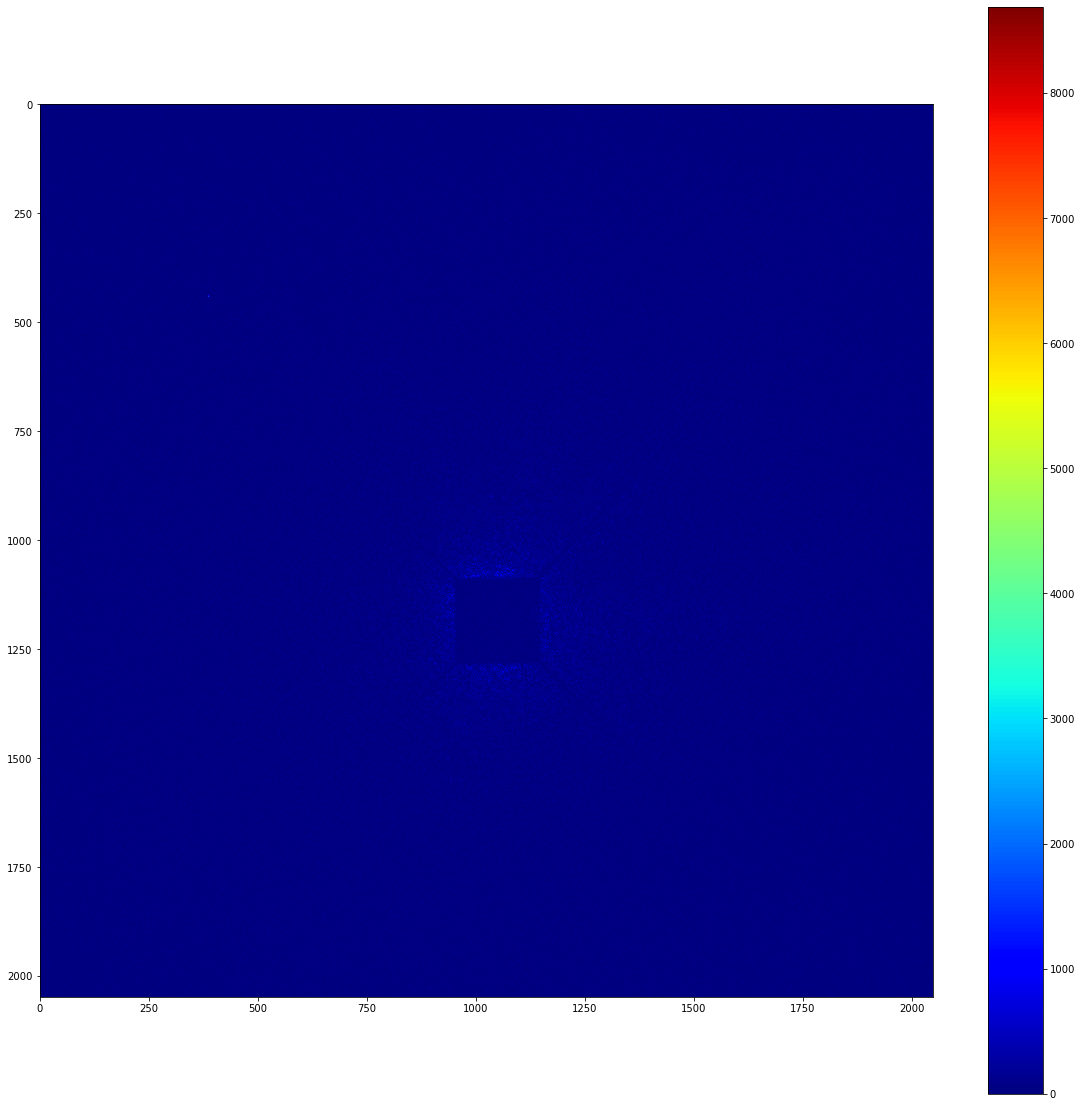

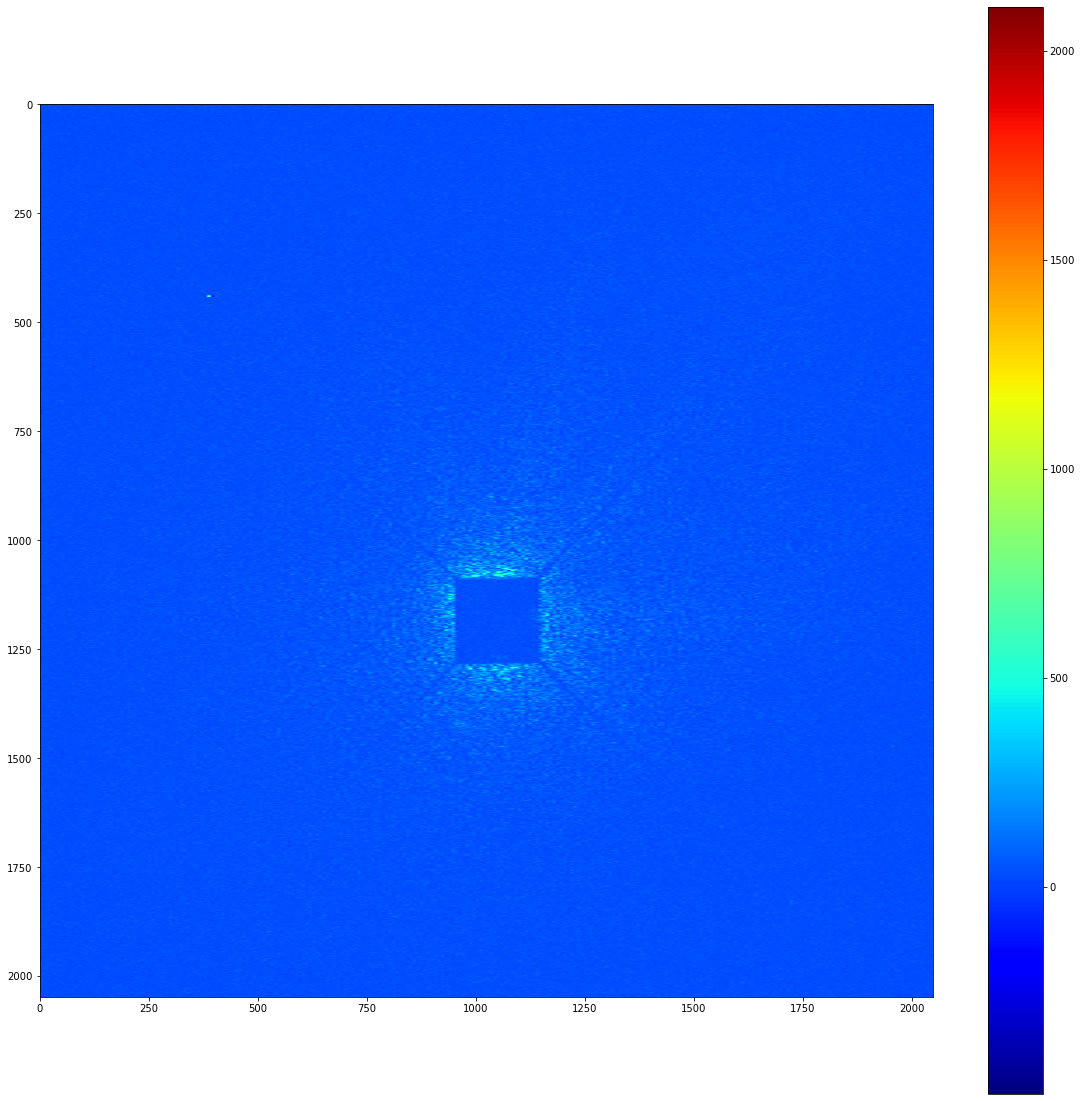

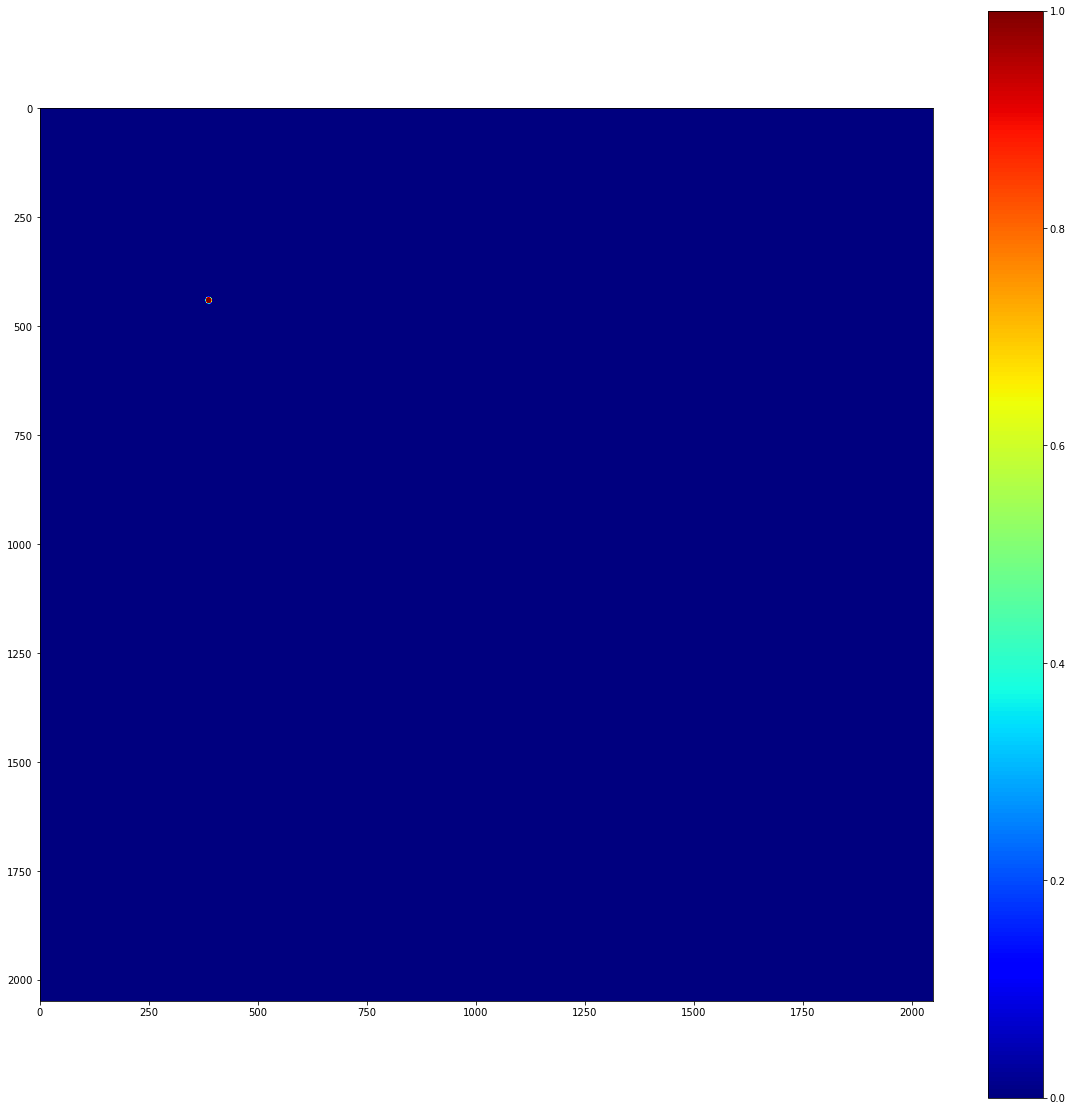

In [ ]:
"""
Lets write a script to inspect all the weird data points.
"""

ii = 0
for angle in np.arange(0, 180, 1.5):
    if ii == 5:
        break
    for field in range(30):
        angle_idx = int(angle/1.5)
        state = state_map[angle_idx][field]
        if state == State.UNKNOWN:
            ii += 1
            print(f"UNKNOWN AT ANGLE OF {angle} + {field} mT")
            img = get_tiff_angle_field(angle, field)
            ccdImage = CCDImage(img, get_rough_background_angle(angle), mask, 
                                metadata)
            ccdImage.subtract_bkg()
            imshow(ccdImage.data)
            ccdImage.wavelet_denoise()
            ccdImage.init_significant_pixels(6, 100)
            imshow(ccdImage.data)
            imshow(ccdImage.significant_pixels)
            if ii == 5:
                break

        

/opt/homebrew/Caskroom/miniforge/base/envs/science_general/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/science_general/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


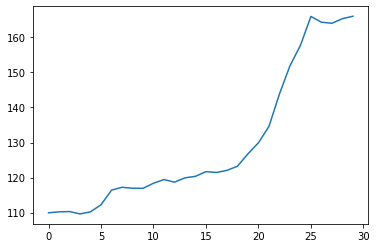

In [ ]:
"""
Work out soliton wavelength as a function of field.
NOTE: 474 mm detector distance.
"""

length_vs_field = []


for field in range(30):
    soliton_lengths = []
    for angle in np.arange(0, 180, 1.5):
        clusters = ALL_CLUSTERS[angle][field]
        pixel_lengths = []
        for cluster in clusters:
            if calculate_state([cluster], angle)[0] == State.SOLITON:
                dx_sq = np.square(cluster.mean[0] - beam_centre_x)
                dy_sq = np.square(cluster.mean[1] - beam_centre_y)
                pixel_dist = np.sqrt(dx_sq + dy_sq)
                pixel_lengths.append(pixel_dist)
        
        avg_soliton_px_length = np.mean(pixel_lengths)
        soliton_length = fitting_constant/avg_soliton_px_length
        soliton_lengths.append(soliton_length)
    
    soliton_lengths = np.ma.array(soliton_lengths, mask=np.isnan(
        soliton_lengths))
    length_vs_field.append(np.mean(soliton_lengths))
    
plt.plot(length_vs_field)

In [ ]:
"""
Let's write some functions to work out cluster intensity information.
"""


def intensity_from_cluster(cluster: cluster.Cluster, field: int, angle: float):
    """
    Returns the background subtracted intensity contained within a cluster.
    """
    # Initialize the CCDImage object.
    scan_dir_idx = int(angle/1.5)
    scan_dir = scan_dirs[scan_dir_idx]
    tiff = get_tiff(scan_dir, field)
    ccdImage = CCDImage(tiff, get_rough_background(scan_dir), mask, metadata)

    # Subtract the background.
    ccdImage.subtract_bkg()

    # Integrate under the cluster.
    x, y = cluster.pixel_indices
    return np.sum(ccdImage.data[y, x])
